# Food-101 Dataset Classification

Food-101 Dataset - https://www.kaggle.com/datasets/kmader/food41

* Contains 101 types of food, with a total of 101,000 images.

* Each category has 250 test images and 750 training images.

Algorithms - CNN, Transfer Learning (Inception V3), Vision Transformer

# Importing libraries and loading data

In [1]:
!pip install kaggle
!pip install tensorflow
!pip install --upgrade tensorflow
!pip install vit_keras
!pip install --upgrade vit_keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.0 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.3.1 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 34.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [2]:
import os
import json
import shutil
import datetime
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras import layers
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
print(tf.__version__)

2.13.0


In [4]:
# Upload your Kaggle API key file - kaggle.json
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d kmader/food41 -p /content/kmader --unzip

100% 5.30G/5.30G [00:38<00:00, 155MB/s]
100% 5.30G/5.30G [00:38<00:00, 147MB/s]


In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [9]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU as the computation device
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Error handling
        print(e)


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# EDA & Pre-processing

In [ ]:
# Directory where original food image data are stored.
root_dir = "/content/kmader/images/"

In [ ]:
# Iterate through the folders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)

    # Check if the path corresponds to a directory
    if os.path.isdir(folder_path):
        # Get the number of image files in the folder
        num_images = len(os.listdir(folder_path))

        # Print the folder name and the number of images
        print(f"Folder: {folder_name}, Number of Images: {num_images}")

Folder: breakfast_burrito, Number of Images: 1000
Folder: hummus, Number of Images: 1000
Folder: caprese_salad, Number of Images: 1000
Folder: tacos, Number of Images: 1000
Folder: greek_salad, Number of Images: 1000
Folder: caesar_salad, Number of Images: 1000
Folder: spring_rolls, Number of Images: 1000
Folder: french_onion_soup, Number of Images: 1000
Folder: macarons, Number of Images: 1000
Folder: beef_tartare, Number of Images: 1000
Folder: paella, Number of Images: 1000
Folder: ravioli, Number of Images: 1000
Folder: seaweed_salad, Number of Images: 1000
Folder: poutine, Number of Images: 1000
Folder: clam_chowder, Number of Images: 1000
Folder: chicken_curry, Number of Images: 1000
Folder: omelette, Number of Images: 1000
Folder: escargots, Number of Images: 1000
Folder: fish_and_chips, Number of Images: 1000
Folder: beef_carpaccio, Number of Images: 1000
Folder: grilled_cheese_sandwich, Number of Images: 1000
Folder: scallops, Number of Images: 1000
Folder: oysters, Number of 

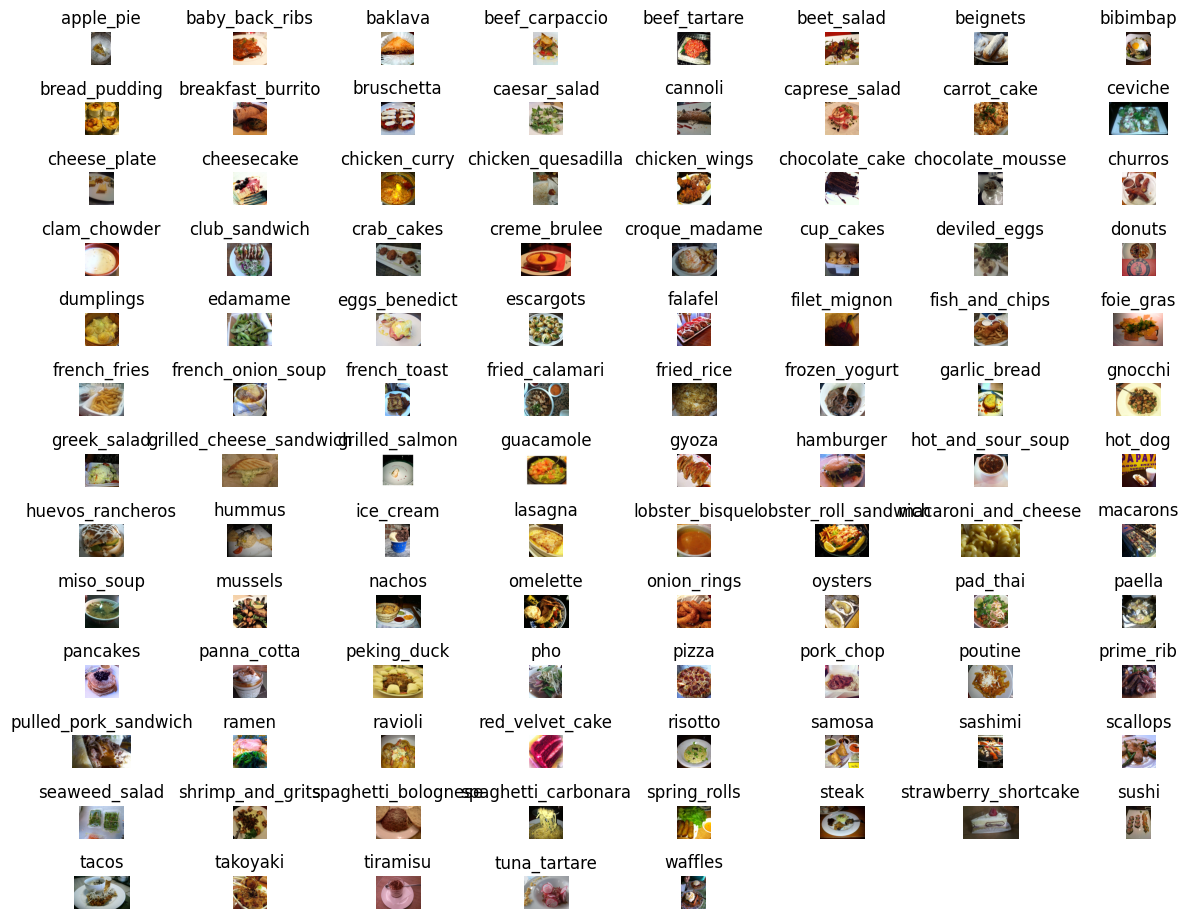

In [ ]:
num_rows = 14

folder_names = sorted(os.listdir(root_dir))
num_folders = len(folder_names)
num_columns = (num_folders + num_rows - 1) // num_rows

fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 10))

# Loop through each folder
for i, folder_name in enumerate(folder_names):
    folder_path = os.path.join(root_dir, folder_name)

    # Get the first image file in the folder
    image_files = sorted(os.listdir(folder_path))
    first_image = os.path.join(folder_path, image_files[0])

    # Load and display the image
    image = Image.open(first_image)
    ax = axs[i // num_columns, i % num_columns]
    ax.imshow(image)
    ax.set_title(folder_name)
    ax.axis('off')

# Remove empty subplots
if num_folders < num_rows * num_columns:
    for i in range(num_folders, num_rows * num_columns):
        fig.delaxes(axs.flatten()[i])

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()

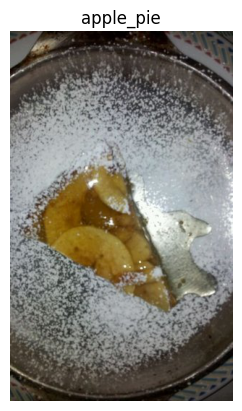

Image Details:
Width: 308
Height: 512
Format: JPEG
Mode: RGB


In [ ]:
selected_folder = "apple_pie"  # Replace with the desired folder name
selected_image_index = 0  # Replace with the desired index of the image within the folder

folder_path = os.path.join(root_dir, selected_folder)
image_files = sorted(os.listdir(folder_path))
selected_image_path = os.path.join(folder_path, image_files[selected_image_index])

# Load and display the image
image = Image.open(selected_image_path)
plt.imshow(image)
plt.title(selected_folder)
plt.axis('off')
plt.show()

# Get image details
image_width, image_height = image.size
image_format = image.format
image_mode = image.mode
image_size = image.size

print("Image Details:")
print("Width:", image_width)
print("Height:", image_height)
print("Format:", image_format)
print("Mode:", image_mode)

# Create TRAIN and TEST folders

In [11]:
# Create class to label mapping
meta_dir = "/content/kmader/meta/meta/"
classes_file = meta_dir + "classes.txt"
labels_file = meta_dir + "labels.txt"
class_label_mapping = {}

with open(classes_file) as textfile1, open(labels_file) as textfile2:
        for x, y in zip(textfile1, textfile2):
            x = x.strip()
            y = y.strip()
            class_label_mapping[x] = y

print(class_label_mapping)
class_labels = list(class_label_mapping.keys())
# train_json_file = meta_dir + "train.json"
# test_json_file = meta_dir + "test.json"
# train_json = json.load(open(train_json_file))
# test_json = json.load(open(test_json_file))
# for key, value in train_json.items():
#   if not len(value) == 750:
#     print(key)
# for key, value in test_json.items():
#   if not len(value) == 250:
#     print(key)

{'apple_pie': 'Apple pie', 'baby_back_ribs': 'Baby back ribs', 'baklava': 'Baklava', 'beef_carpaccio': 'Beef carpaccio', 'beef_tartare': 'Beef tartare', 'beet_salad': 'Beet salad', 'beignets': 'Beignets', 'bibimbap': 'Bibimbap', 'bread_pudding': 'Bread pudding', 'breakfast_burrito': 'Breakfast burrito', 'bruschetta': 'Bruschetta', 'caesar_salad': 'Caesar salad', 'cannoli': 'Cannoli', 'caprese_salad': 'Caprese salad', 'carrot_cake': 'Carrot cake', 'ceviche': 'Ceviche', 'cheesecake': 'Cheesecake', 'cheese_plate': 'Cheese plate', 'chicken_curry': 'Chicken curry', 'chicken_quesadilla': 'Chicken quesadilla', 'chicken_wings': 'Chicken wings', 'chocolate_cake': 'Chocolate cake', 'chocolate_mousse': 'Chocolate mousse', 'churros': 'Churros', 'clam_chowder': 'Clam chowder', 'club_sandwich': 'Club sandwich', 'crab_cakes': 'Crab cakes', 'creme_brulee': 'Creme brulee', 'croque_madame': 'Croque madame', 'cup_cakes': 'Cup cakes', 'deviled_eggs': 'Deviled eggs', 'donuts': 'Donuts', 'dumplings': 'Dumpl

In [12]:
# # Delete the directory if already exists
# shutil.rmtree('/content/kmader/test')
# shutil.rmtree('/content/kmader/train')

meta_dir = "/content/kmader/meta/meta/"
root_dir = "/content/kmader/images/"
train_dir = "/content/kmader/train/"
test_dir = "/content/kmader/test/"
train_json_file = meta_dir + "train.json"
test_json_file = meta_dir + "test.json"

train_json = json.load(open(train_json_file))
test_json = json.load(open(test_json_file))

train_rejected_files = []
test_rejected_files = []  # List to store the rejected files

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move train images to the train directory
for key, value in train_json.items():
    for img in value:
        img_class = key
        class_dir = os.path.join(train_dir, img_class)
        os.makedirs(class_dir, exist_ok=True)

        img_number = img.split("/")[1]
        src = os.path.join(root_dir, img + ".jpg")
        dst = os.path.join(class_dir, img_number + ".jpg")

        try:
            shutil.copyfile(src, dst)
        except FileNotFoundError:
            train_rejected_files.append(src)
            continue

# Move test images to the test directory
for key, value in test_json.items():
    for img in value:
        img_class = key
        class_dir = os.path.join(test_dir, img_class)
        os.makedirs(class_dir, exist_ok=True)

        img_number = img.split("/")[1]
        src = os.path.join(root_dir, img + ".jpg")
        dst = os.path.join(class_dir, img_number + ".jpg")

        try:
            shutil.copyfile(src, dst)
        except FileNotFoundError:
            test_rejected_files.append(src)
            continue

In [13]:
print("Train Rejected files:", train_rejected_files)
print("Test Rejected files:", test_rejected_files)
print("Train Rejected files:", len(train_rejected_files))
print("Test Rejected files:", len(test_rejected_files))

Train Rejected files: []
Test Rejected files: []
Train Rejected files: 0
Test Rejected files: 0


# Training

## Training with 2 categories - Apple Pie and Pizza

In [ ]:
selected_folders = ["apple_pie", "pizza"]
num_classes = 2
batch_size = 128
# Define the desired image size
image_size = (224, 224)

images = []
labels = []

# Load the images and labels
for folder_name in selected_folders:
    folder_path = os.path.join(root_dir, folder_name)
    image_files = sorted(os.listdir(folder_path))

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        image = image.resize(image_size)  # Resize the image
        image = np.array(image)
        images.append(image)
        labels.append(folder_name)

In [ ]:
# Convert the images and labels into numpy arrays
X = np.array(images)
y = np.array(labels)

In [ ]:
# Preprocess the image data
X = X / 255.0  # Normalize the pixel values

# Convert the labels into one-hot encoded vectors
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_onehot = to_categorical(y_encoded, num_classes)

In [ ]:
print(X.shape, y_onehot.shape)

(2000, 224, 224, 3) (2000, 2)


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape", y_train.shape)
print("y_val shape", y_val.shape)

X_train shape: (1600, 224, 224, 3)
X_val shape: (400, 224, 224, 3)
y_train shape (1600, 2)
y_val shape (400, 2)


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size)

Epoch 1/10
13/13 [==============================] - 5s 239ms/step - loss: 0.9762 - accuracy: 0.5100 - val_loss: 0.6705 - val_accuracy: 0.6025
Epoch 2/10
13/13 [==============================] - 2s 181ms/step - loss: 0.6280 - accuracy: 0.6531 - val_loss: 0.5965 - val_accuracy: 0.6700
Epoch 3/10
13/13 [==============================] - 2s 183ms/step - loss: 0.5617 - accuracy: 0.7200 - val_loss: 0.5204 - val_accuracy: 0.7525
Epoch 4/10
13/13 [==============================] - 2s 183ms/step - loss: 0.5550 - accuracy: 0.7225 - val_loss: 0.5238 - val_accuracy: 0.7175
Epoch 5/10
13/13 [==============================] - 2s 183ms/step - loss: 0.5286 - accuracy: 0.7344 - val_loss: 0.5238 - val_accuracy: 0.7275
Epoch 6/10
13/13 [==============================] - 2s 183ms/step - loss: 0.4639 - accuracy: 0.7987 - val_loss: 0.5719 - val_accuracy: 0.6975
Epoch 7/10
13/13 [==============================] - 2s 184ms/step - loss: 0.4237 - accuracy: 0.8119 - val_loss: 0.4964 - val_accuracy: 0.7750
Epoch 

In [ ]:
test_error, test_accuracy = model.evaluate(X_val, y_val, verbose=1)
print("Test accuracy: ", test_accuracy)

13/13 [==============================] - 0s 17ms/step - loss: 0.5280 - accuracy: 0.7700
Test accuracy:  0.7699999809265137


In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=np.unique(labels), zero_division=0)

# Print the classification report
print(report)

13/13 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

   apple_pie       0.75      0.80      0.78       199
       pizza       0.79      0.74      0.76       201

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400



### Accuracy & Loss Curves

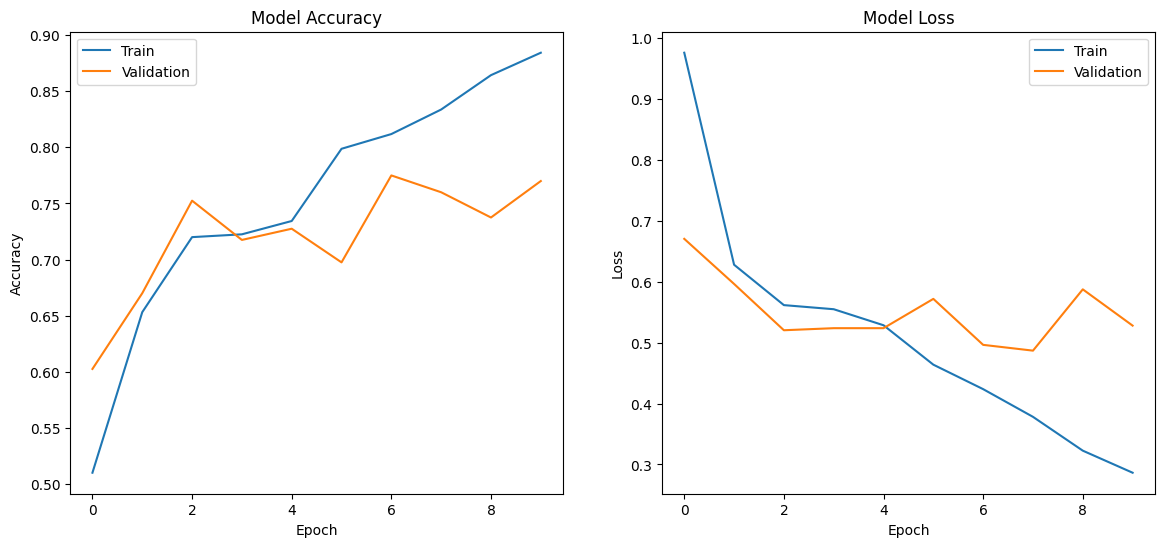

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

### Confusion Matrix

13/13 [==============================] - 0s 15ms/step


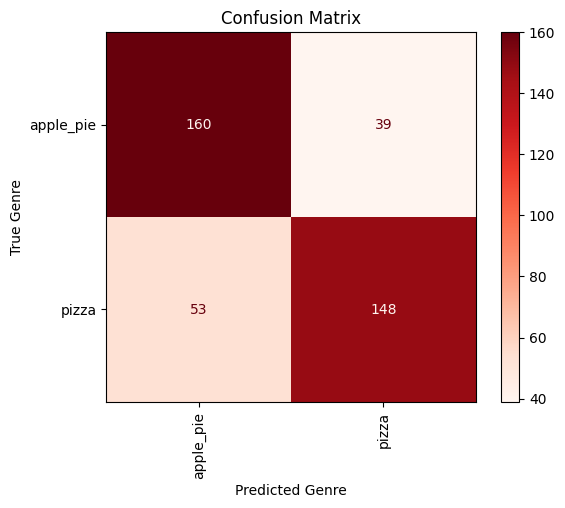

In [ ]:
# Assuming you have the model and the validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.show()

## Training with 11 categories

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    shutil.rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    shutil.copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
n = 11
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread',
             'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
# food_list = class_labels[:n]
src_train = '/content/kmader/train/'
dest_train = '/content/kmader/train_'+str(n)
src_test = '/content/kmader/test/'
dest_test = '/content/kmader/test_'+str(n)
dataset_mini(food_list, src_train, dest_train)
dataset_mini(food_list, src_test, dest_test)

Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
batch_size = 128
image_size = (224, 224)

# Split the data into train, validation, and test sets
train_dir = "/content/kmader/train_11"
test_dir = "/content/kmader/test_11"
selected_folders = os.listdir(train_dir)
num_classes = len(selected_folders)
print("Number of classes", num_classes)

# Create an ImageDataGenerator for data augmentation and preprocessing
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_data_generator = ImageDataGenerator(
    rescale=1./255
)

# Generate the train set
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate the test set
validation_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

train_steps_per_epoch = train_generator.samples // batch_size
validation_steps_per_epoch = validation_generator.samples // batch_size

Number of classes 11
Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


In [ ]:
class_map_11 = train_generator.class_indices
class_labels_11 = list(class_map_11.keys())
print(class_map_11, class_labels_11)

{'apple_pie': 0, 'beef_carpaccio': 1, 'bibimbap': 2, 'cup_cakes': 3, 'foie_gras': 4, 'french_fries': 5, 'garlic_bread': 6, 'pizza': 7, 'spaghetti_carbonara': 8, 'spring_rolls': 9, 'strawberry_shortcake': 10} ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spaghetti_carbonara', 'spring_rolls', 'strawberry_shortcake']


### CNN

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Use dropout for regularization
model.add(Dense(11, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce LR callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/30
65/65 [==============================] - 140s 2s/step - loss: 2.3760 - accuracy: 0.1904 - val_loss: 1.9856 - val_accuracy: 0.3105 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 136s 2s/step - loss: 2.0431 - accuracy: 0.2945 - val_loss: 1.9030 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 135s 2s/step - loss: 1.9566 - accuracy: 0.3263 - val_loss: 1.7344 - val_accuracy: 0.4193 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 135s 2s/step - loss: 1.8881 - accuracy: 0.3492 - val_loss: 1.6831 - val_accuracy: 0.4360 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 136s 2s/step - loss: 1.8303 - accuracy: 0.3759 - val_loss: 1.5921 - val_accuracy: 0.4618 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 135s 2s/step - loss: 1.7835 - accuracy: 0.3886 - val_loss: 1.5795 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 137s 2s/step - loss: 1.7

In [ ]:
# Save and Download the model file
model.save('/content/model/cnn/cnn_11.h5')
files.download('/content/model/cnn/cnn_11.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_error, test_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test accuracy: ", test_accuracy)

22/22 [==============================] - 15s 682ms/step - loss: 1.3030 - accuracy: 0.5829
Test accuracy:  0.582909107208252


In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

# Continue with classification_report and print the report
category_names = list(train_generator.class_indices.keys())

report = classification_report(y_true_classes, y_pred_classes, target_names=category_names, zero_division=0)
# Print the classification report
print(report)

4/4 [==============================] - 0s 22ms/step
                      precision    recall  f1-score   support

           apple_pie       0.38      0.38      0.38       242
      beef_carpaccio       0.74      0.68      0.71       235
            bibimbap       0.64      0.79      0.70       224
           cup_cakes       0.58      0.61      0.59       241
           foie_gras       0.42      0.73      0.53       245
        french_fries       0.63      0.59      0.61       228
        garlic_bread       0.50      0.28      0.36       240
               pizza       0.69      0.58      0.63       237
 spaghetti_carbonara       0.77      0.71      0.74       248
        spring_rolls       0.53      0.46      0.49       239
strawberry_shortcake       0.72      0.64      0.68       243

            accuracy                           0.59      2622
           macro avg       0.60      0.59      0.58      2622
        weighted avg       0.60      0.59      0.58      2622



Accuracy & Loss Curves

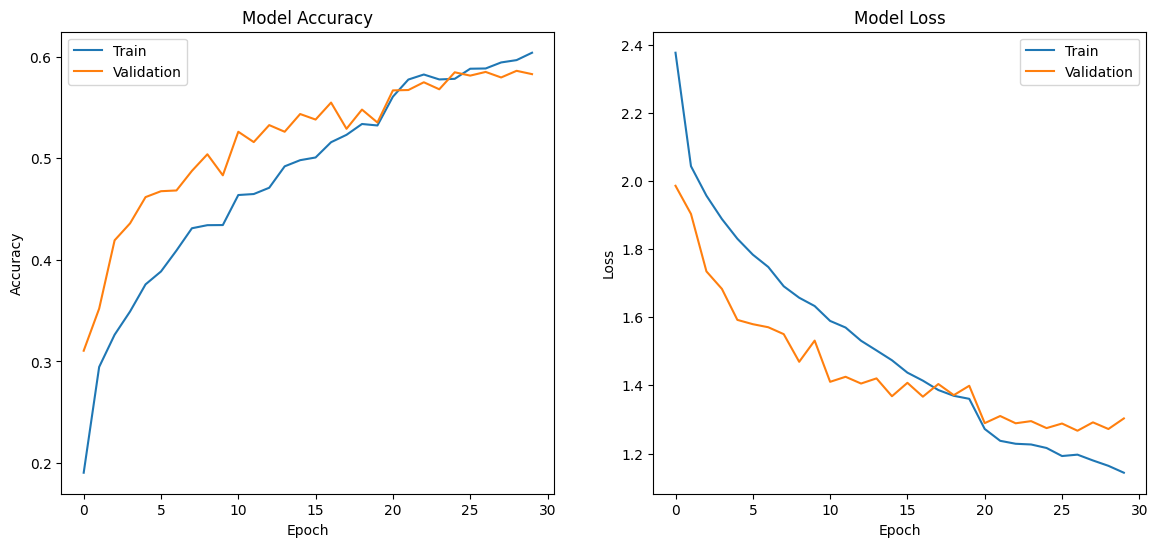

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

Confusion Matrix

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

4/4 [==============================] - 0s 18ms/step


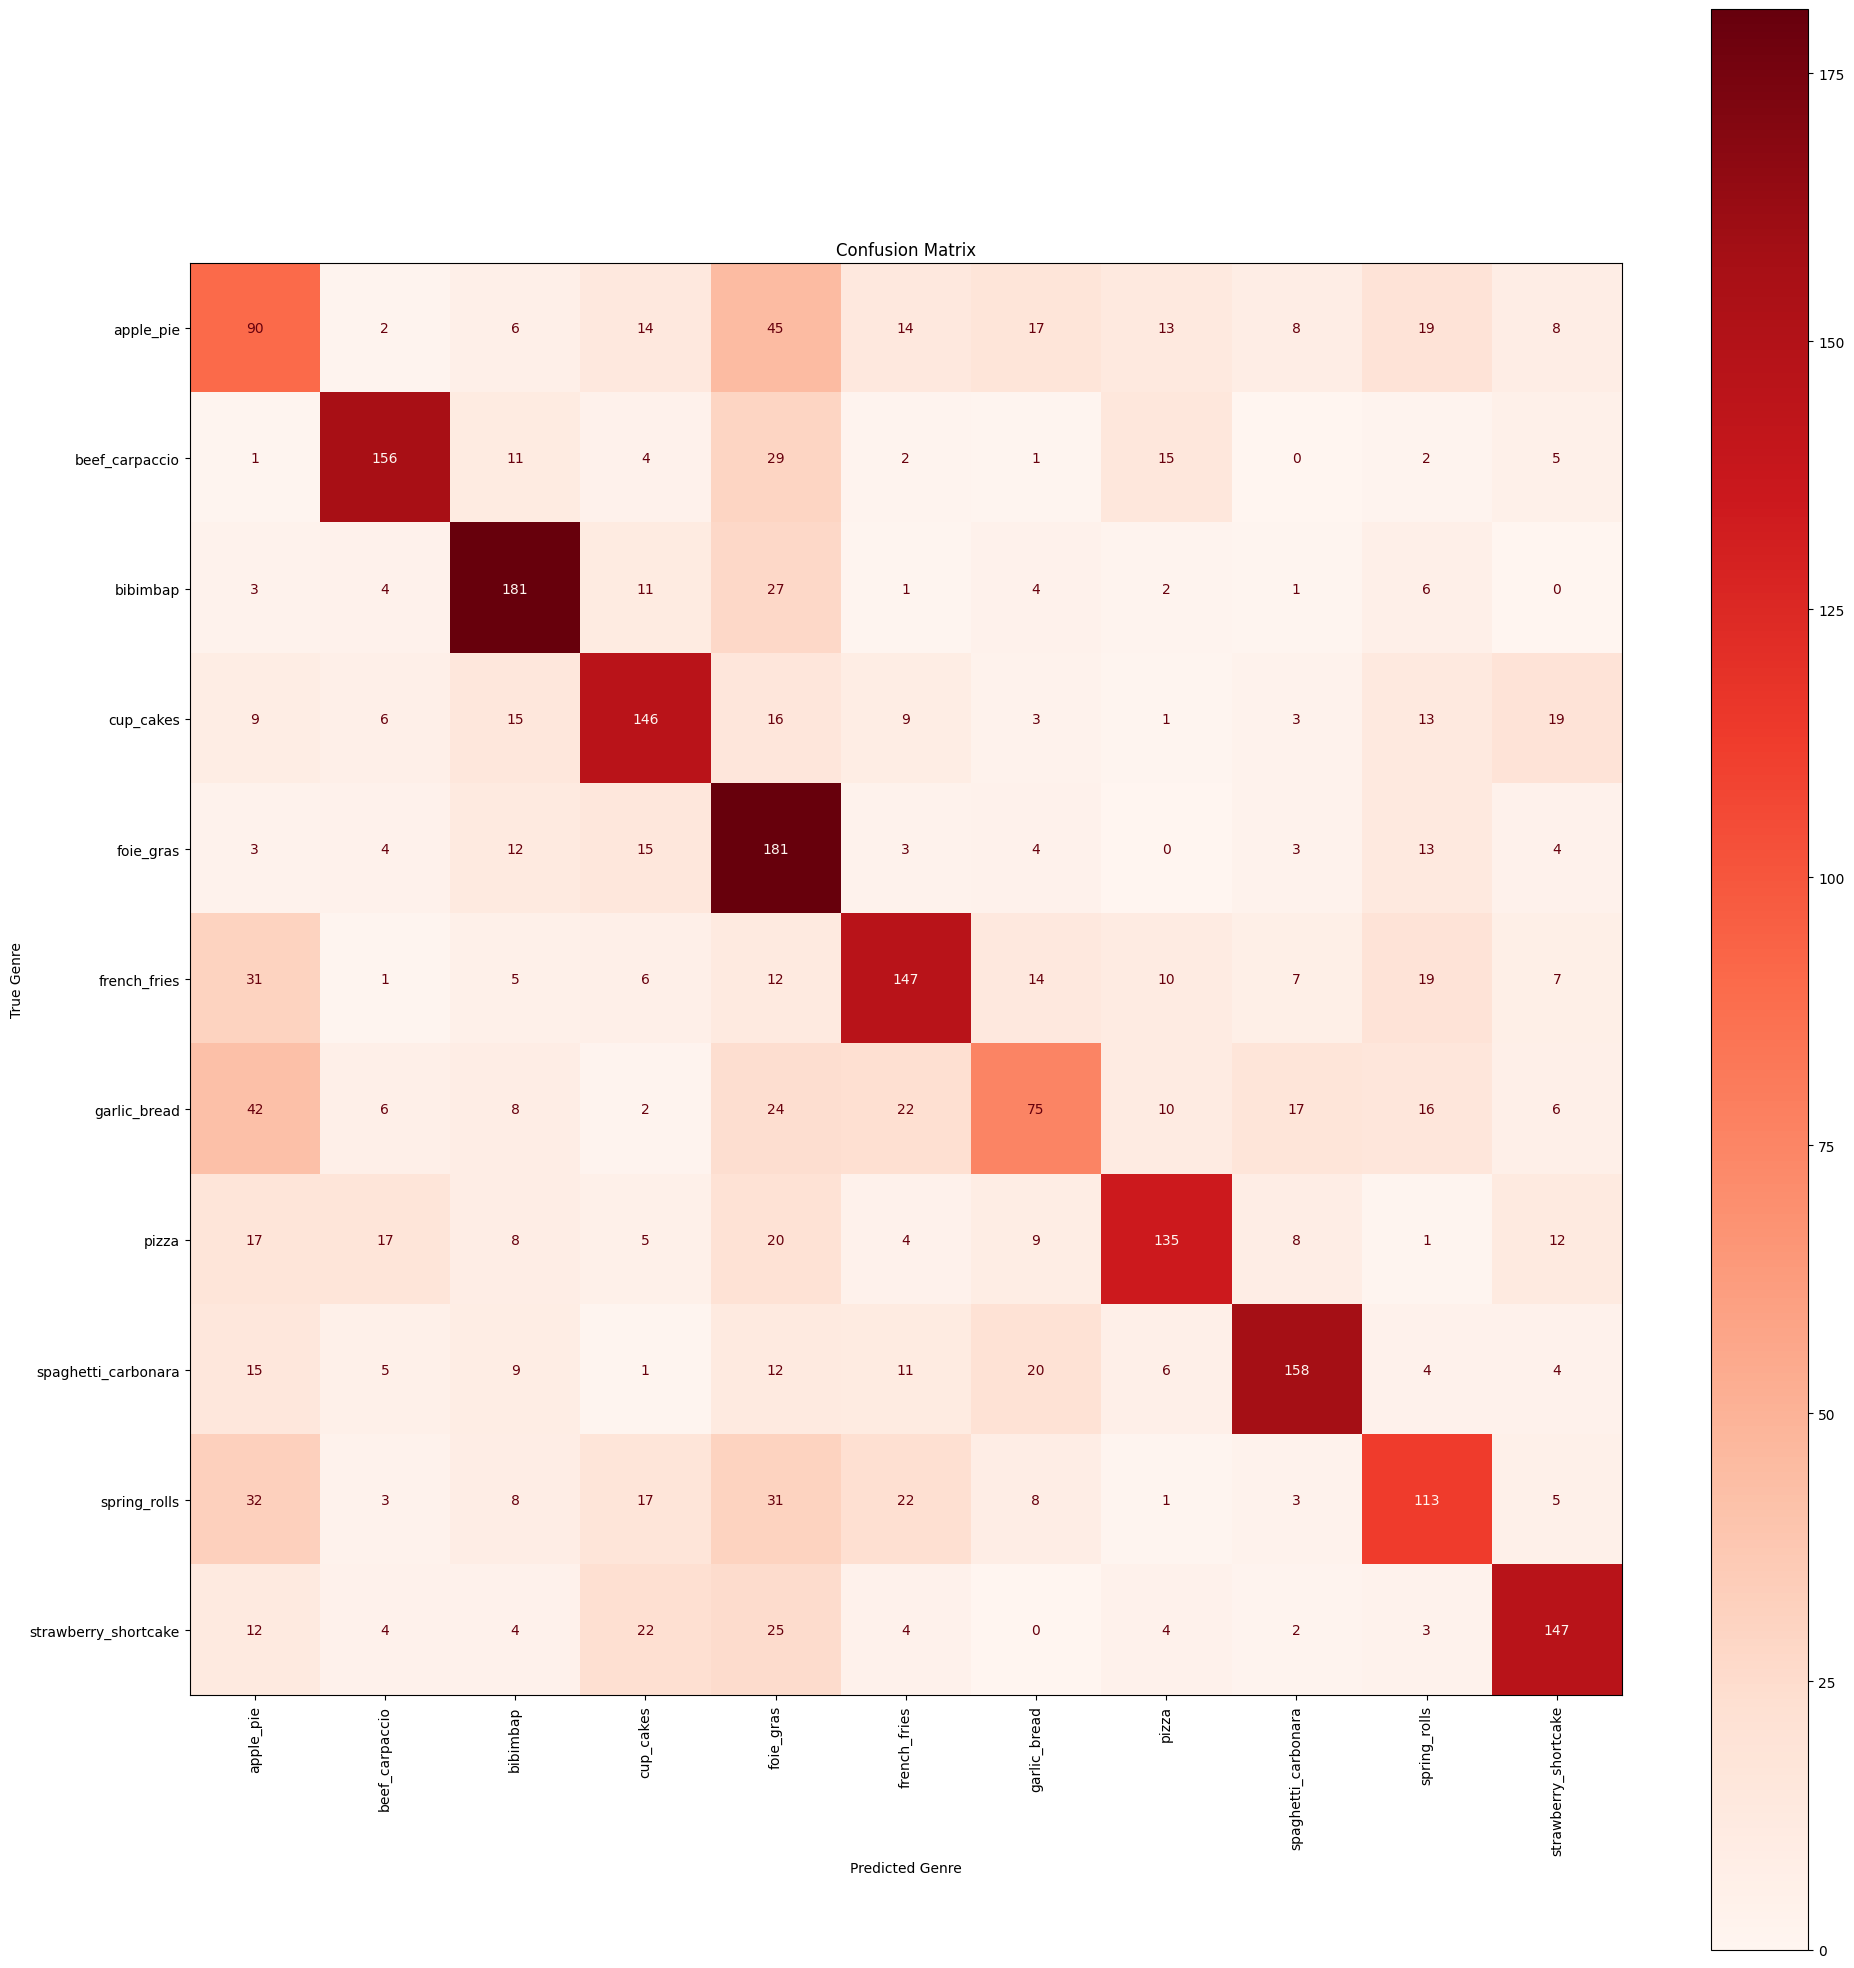

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_names)

# Adjust figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

### InceptionV3

In [ ]:
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = inceptionv3.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inceptionv3.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# checkpointer = ModelCheckpoint(filepath='/content/model/inceptionv3/best_model_3class.hdf5', verbose=1, save_best_only=True)
# csv_logger = CSVLogger('/content/model/inceptionv3/history_3class.log')

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps_per_epoch,
                    epochs=30,
                    verbose=1
                    # callbacks=[csv_logger, checkpointer]
                    )

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/30
64/64 [==============================] - 165s 2s/step - loss: 2.6160 - accuracy: 0.1049 - val_loss: 2.5042 - val_accuracy: 0.1443
Epoch 2/30
64/64 [==============================] - 126s 2s/step - loss: 2.4289 - accuracy: 0.1699 - val_loss: 2.2532 - val_accuracy: 0.2924
Epoch 3/30
64/64 [==============================] - 125s 2s/step - loss: 2.2926 - accuracy: 0.2583 - val_loss: 2.0984 - val_accuracy: 0.4137
Epoch 4/30
64/64 [==============================] - 125s 2s/step - loss: 2.1473 - accuracy: 0.3516 - val_loss: 1.9556 - val_accuracy: 0.4836
Epoch 5/30
64/64 [==============================] - 124s 2s/step - loss: 2.0193 - accuracy: 0.4149 - val_loss: 1.8259 - val_accuracy: 0.5424
Epoch 6/30
64/64 [==============================] - 124s 2s/step - loss: 1.8908 - accuracy: 0.4660 - val_loss: 1.6957 - val_accuracy: 0.5848
Epoch 7/30
64/64 [==============================] - 123s 2s/step - loss: 1.7696 - accurac

In [ ]:
# Save and Download the model file
model.save('/content/model/inceptionv3/inceptionv3_model_11.h5')
files.download('/content/model/inceptionv3/inceptionv3_model_11.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_error, test_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test accuracy: ", test_accuracy)

22/22 [==============================] - 17s 767ms/step - loss: 0.5766 - accuracy: 0.8575
Test accuracy:  0.8574545383453369


In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

# Continue with classification_report and print the report
category_names = list(train_generator.class_indices.keys())

report = classification_report(y_true_classes, y_pred_classes, target_names=category_names, zero_division=0)
# Print the classification report
print(report)

4/4 [==============================] - 0s 63ms/step
                      precision    recall  f1-score   support

           apple_pie       0.72      0.68      0.70       245
      beef_carpaccio       0.81      0.84      0.83       245
            bibimbap       0.94      0.91      0.92       247
           cup_cakes       0.93      0.93      0.93       242
           foie_gras       0.77      0.76      0.77       246
        french_fries       0.95      0.94      0.94       246
        garlic_bread       0.81      0.81      0.81       243
               pizza       0.89      0.89      0.89       244
 spaghetti_carbonara       0.94      0.93      0.94       241
        spring_rolls       0.85      0.87      0.86       244
strawberry_shortcake       0.82      0.88      0.85       245

            accuracy                           0.86      2688
           macro avg       0.86      0.86      0.86      2688
        weighted avg       0.86      0.86      0.86      2688



Accuracy & Loss Curves

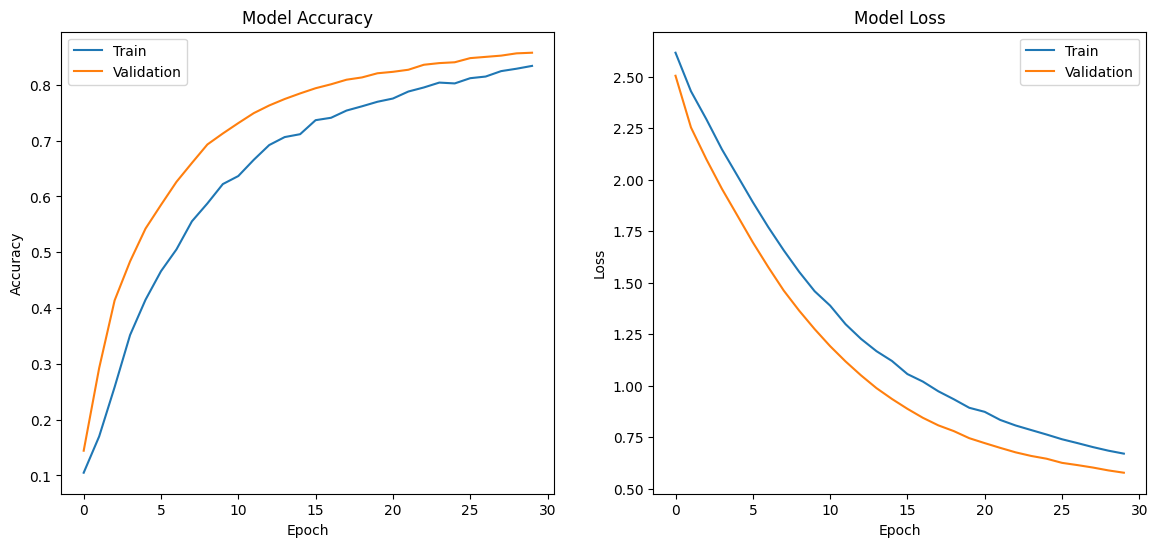

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

Confusion Matrix

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

4/4 [==============================] - 0s 63ms/step


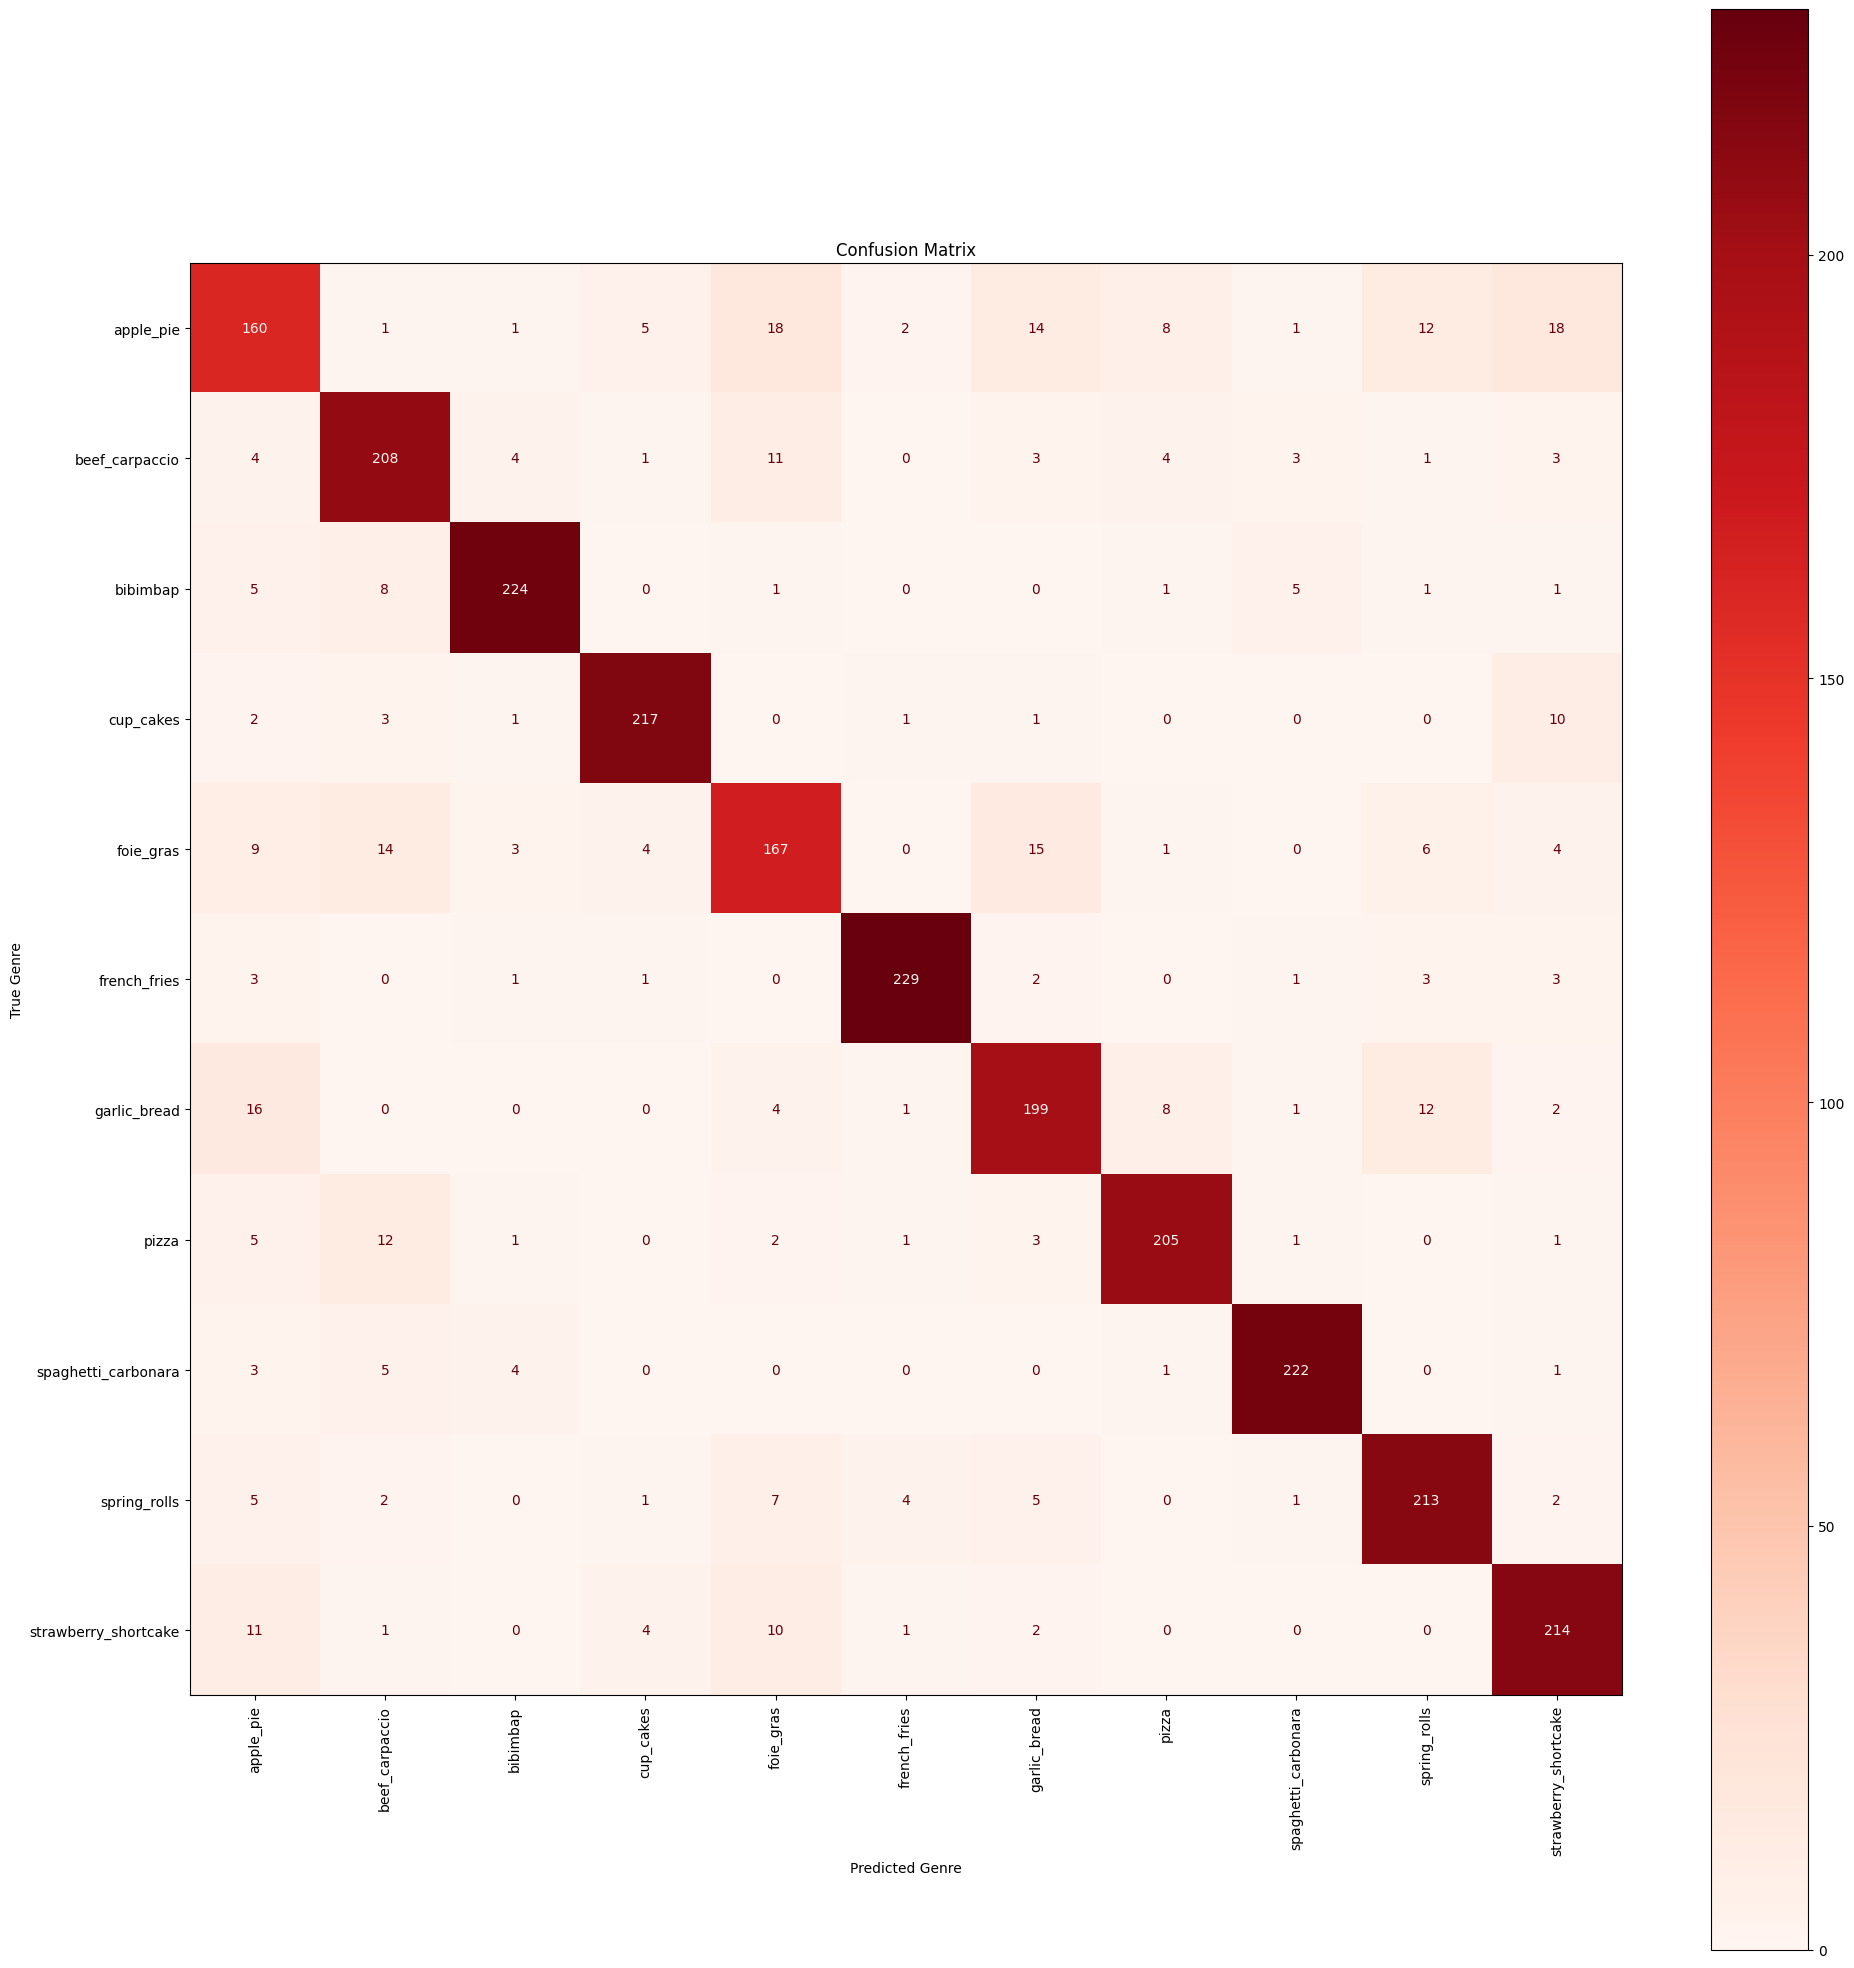

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_names)

# Adjust figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

### ResNet50

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps_per_epoch,
                    epochs=30,
                    verbose=1
                    )

Epoch 1/30
64/64 [==============================] - 163s 2s/step - loss: 2.6459 - accuracy: 0.1338 - val_loss: 2.7821 - val_accuracy: 0.0833
Epoch 2/30
64/64 [==============================] - 143s 2s/step - loss: 2.2444 - accuracy: 0.2662 - val_loss: 2.9812 - val_accuracy: 0.0915
Epoch 3/30
64/64 [==============================] - 141s 2s/step - loss: 1.9611 - accuracy: 0.3940 - val_loss: 3.0472 - val_accuracy: 0.0971
Epoch 4/30
64/64 [==============================] - 142s 2s/step - loss: 1.7533 - accuracy: 0.4798 - val_loss: 3.1394 - val_accuracy: 0.1049
Epoch 5/30
64/64 [==============================] - 141s 2s/step - loss: 1.5572 - accuracy: 0.5419 - val_loss: 3.2175 - val_accuracy: 0.1034
Epoch 6/30
64/64 [==============================] - 142s 2s/step - loss: 1.4135 - accuracy: 0.5900 - val_loss: 3.2465 - val_accuracy: 0.1097
Epoch 7/30
64/64 [==============================] - 141s 2s/step - loss: 1.2839 - accuracy: 0.6380 - val_loss: 3.1423 - val_accuracy: 0.1220
Epoch 8/30
64

In [ ]:
# Save and Download the model file
model.save('/content/model/resnet50/resnet50_11.h5')
files.download('/content/model/resnet50/resnet50_11.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_error, test_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test accuracy: ", test_accuracy)

22/22 [==============================] - 18s 818ms/step - loss: 0.5036 - accuracy: 0.8658
Test accuracy:  0.865818202495575


In [ ]:
model = load_model('/content/model/resnet50/resnet50_11.h5')
sample_image_path = "/content/kmader/test_11/apple_pie/1011328.jpg"

# Load and preprocess the image
image = load_img(sample_image_path, target_size=(224, 224))
image = img_to_array(image)
image = image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape of the model
image = np.expand_dims(image, axis=0)

# Make predictions
predictions = model.predict(image)

# Get the predicted label
predicted_label = np.argmax(predictions[0])

# Print the predicted label
print("Predicted class and label:", class_labels_11[predicted_label], class_map_11[class_labels_11[predicted_label]])

1/1 [==============================] - 2s 2s/step
Predicted class and label: apple_pie 0


In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

# Continue with classification_report and print the report
category_names = list(train_generator.class_indices.keys())

report = classification_report(y_true_classes, y_pred_classes, target_names=category_names, zero_division=0)
# Print the classification report
print(report)

4/4 [==============================] - 0s 92ms/step
                      precision    recall  f1-score   support

           apple_pie       0.74      0.66      0.70       244
      beef_carpaccio       0.84      0.91      0.87       244
            bibimbap       0.95      0.96      0.95       246
           cup_cakes       0.95      0.90      0.93       243
           foie_gras       0.71      0.83      0.76       245
        french_fries       0.94      0.94      0.94       245
        garlic_bread       0.81      0.83      0.82       246
               pizza       0.90      0.89      0.89       247
 spaghetti_carbonara       0.94      0.92      0.93       243
        spring_rolls       0.90      0.86      0.88       244
strawberry_shortcake       0.87      0.83      0.85       241

            accuracy                           0.87      2688
           macro avg       0.87      0.87      0.87      2688
        weighted avg       0.87      0.87      0.87      2688



Accuracy & Loss Curves

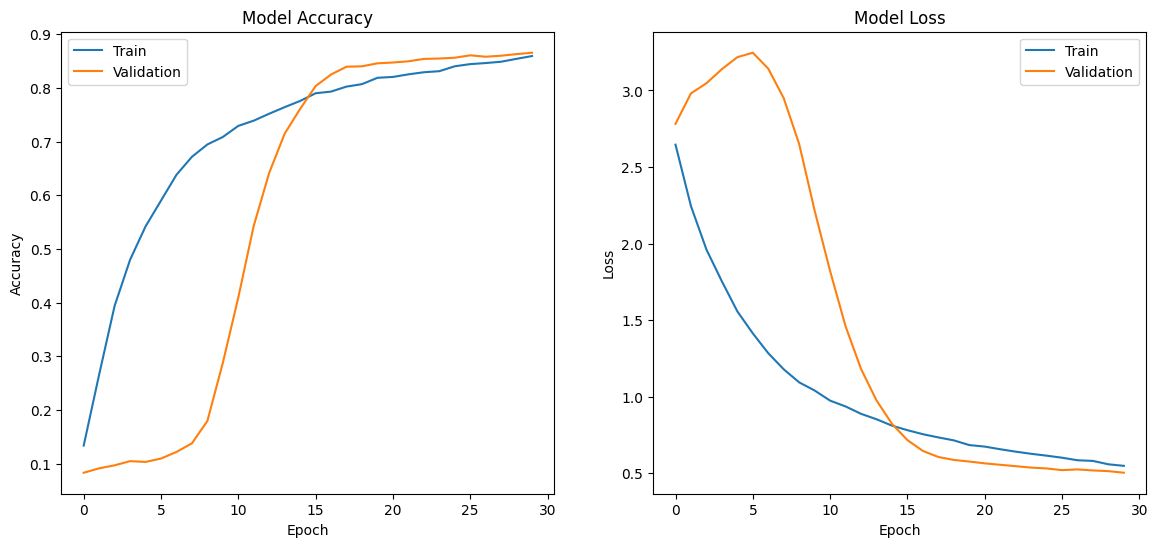

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

Confusion Matrix

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

4/4 [==============================] - 0s 92ms/step


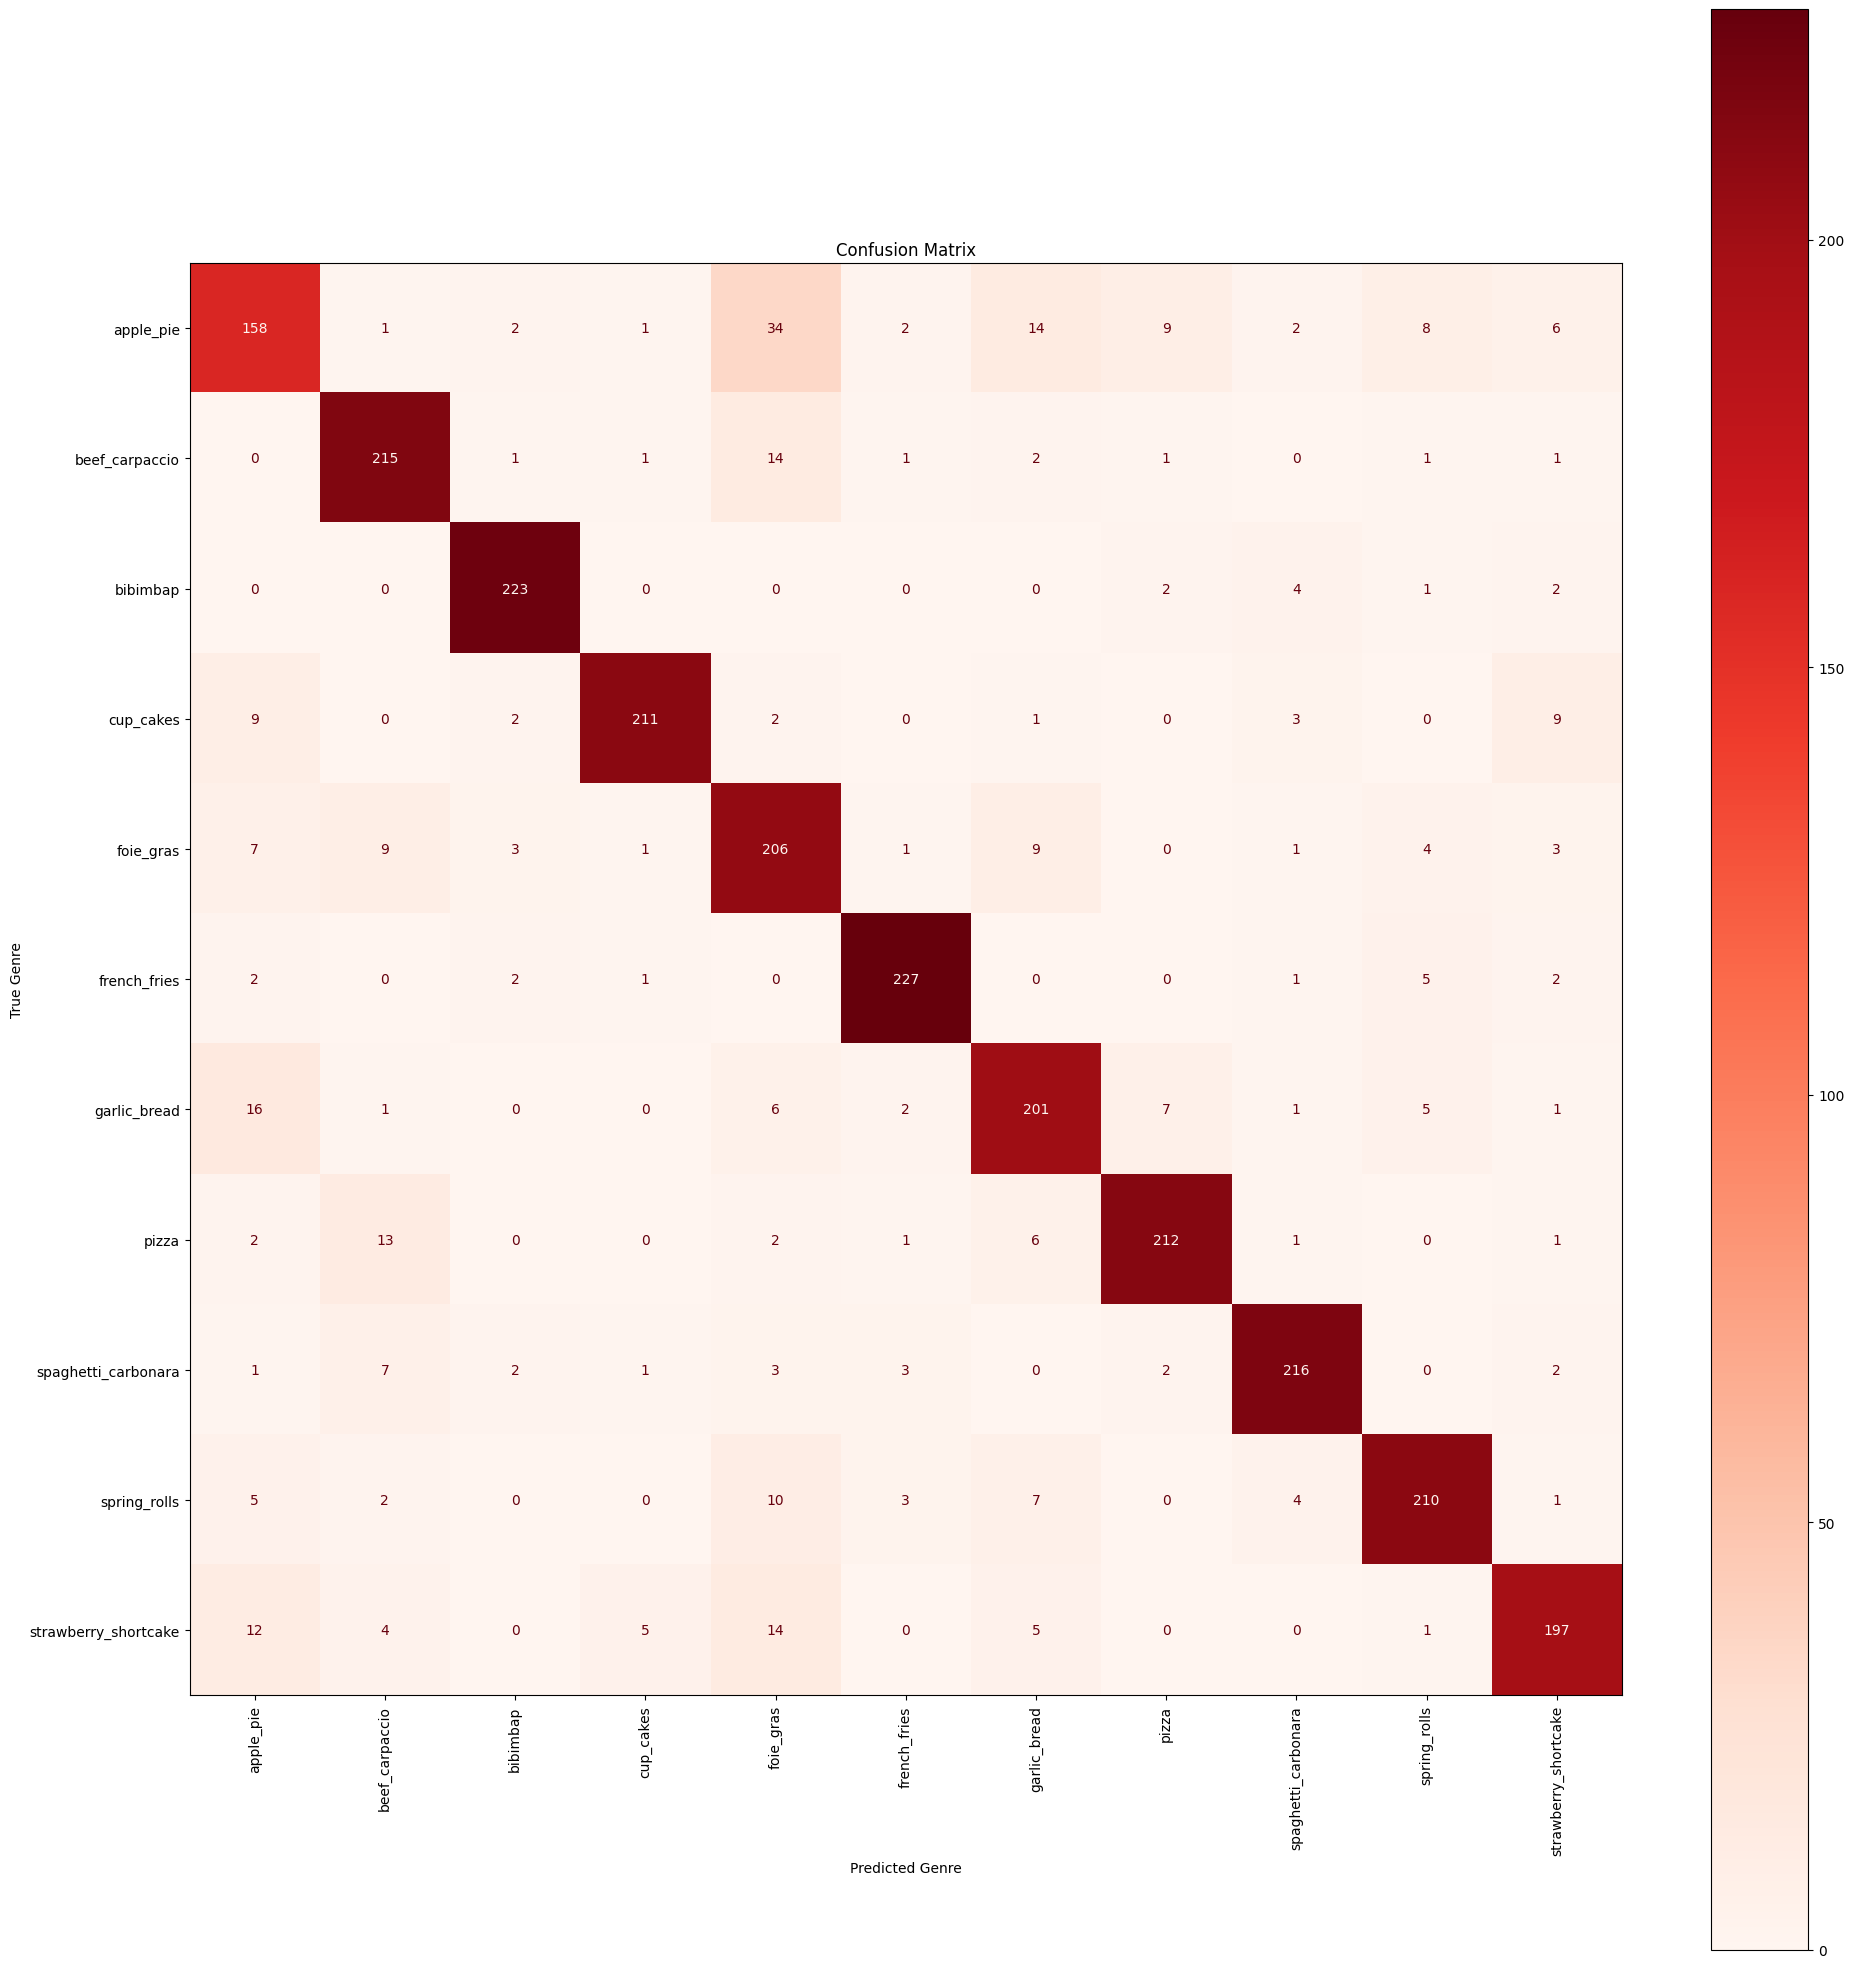

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_names)

# Adjust figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

### Vision Transformer

In [ ]:
# Split the data into train, validation, and test sets
train_dir = "/content/kmader/train_11"
test_dir = "/content/kmader/test_11"
selected_folders = os.listdir(train_dir)
num_classes = len(selected_folders)
print("Number of classes", num_classes)
batch_size = 32
epochs = 30
patch_size = 7
image_size = 224
target_size = (224, 224)

# Create an ImageDataGenerator for data augmentation and preprocessing
train_data_generator = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_data_generator = ImageDataGenerator(
    rescale=1. / 255
)

# Generate the train set
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate the test set
validation_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Number of classes 11
Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


In [ ]:
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


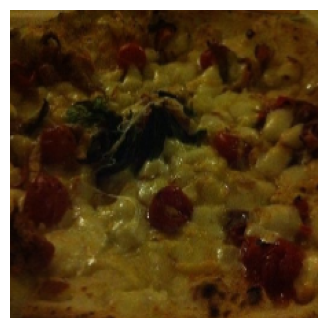

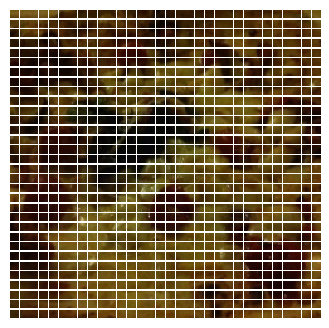

In [ ]:
plt.figure(figsize=(4, 4))
# Calculate the number of patches based on the patch_size and image dimensions
num_patches = (image_size // patch_size) ** 2

image = train_generator[0][0][0]

plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')
plt.show()

In [ ]:
model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tfa.activations.gelu),
    tf.keras.layers.Dense(32, activation=tfa.activations.gelu),
    tf.keras.layers.Dense(num_classes, activation='softmax')
], name='vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)         

In [ ]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)
# optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

train_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch = validation_generator.n // validation_generator.batch_size

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

hidtory = model.fit(train_generator,
          steps_per_epoch = train_steps_per_epoch,
          validation_data = validation_generator,
          validation_steps = validation_steps_per_epoch,
          epochs = epochs,
          callbacks = early_stopping_callbacks)

Epoch 1/30
257/257 [==============================] - 421s 2s/step - loss: 1.7691 - accuracy: 0.5960 - val_loss: 1.1197 - val_accuracy: 0.9496
Epoch 2/30
257/257 [==============================] - 389s 2s/step - loss: 1.1518 - accuracy: 0.9244 - val_loss: 1.0593 - val_accuracy: 0.9555
Epoch 3/30
257/257 [==============================] - 391s 2s/step - loss: 1.0600 - accuracy: 0.9482 - val_loss: 1.0149 - val_accuracy: 0.9629
Epoch 4/30
257/257 [==============================] - 391s 2s/step - loss: 1.0177 - accuracy: 0.9628 - val_loss: 0.9847 - val_accuracy: 0.9673
Epoch 5/30
257/257 [==============================] - 390s 2s/step - loss: 0.9940 - accuracy: 0.9665 - val_loss: 0.9822 - val_accuracy: 0.9647
Epoch 6/30
257/257 [==============================] - 390s 2s/step - loss: 0.9691 - accuracy: 0.9765 - val_loss: 0.9851 - val_accuracy: 0.9632
Epoch 7/30
257/257 [==============================] - 391s 2s/step - loss: 0.9591 - accuracy: 0.9777 - val_loss: 0.9778 - val_accuracy: 0.9632

In [ ]:
# Save the trained model
model.save("/content/gdrive/My Drive/DS 5500/Phase 2/vit/vit_11.h5")

In [ ]:
# After training, evaluate the model on the validation set
test_error, test_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test accuracy: ", test_accuracy)

86/86 [==============================] - 40s 462ms/step - loss: 0.9893 - accuracy: 0.9542
Test accuracy:  0.9541817903518677


Accuracy & Loss Curves

In [51]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

1/1 [==============================] - 0s 33ms/step


Confusion Matrix

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

1/1 [==============================] - 0s 33ms/step


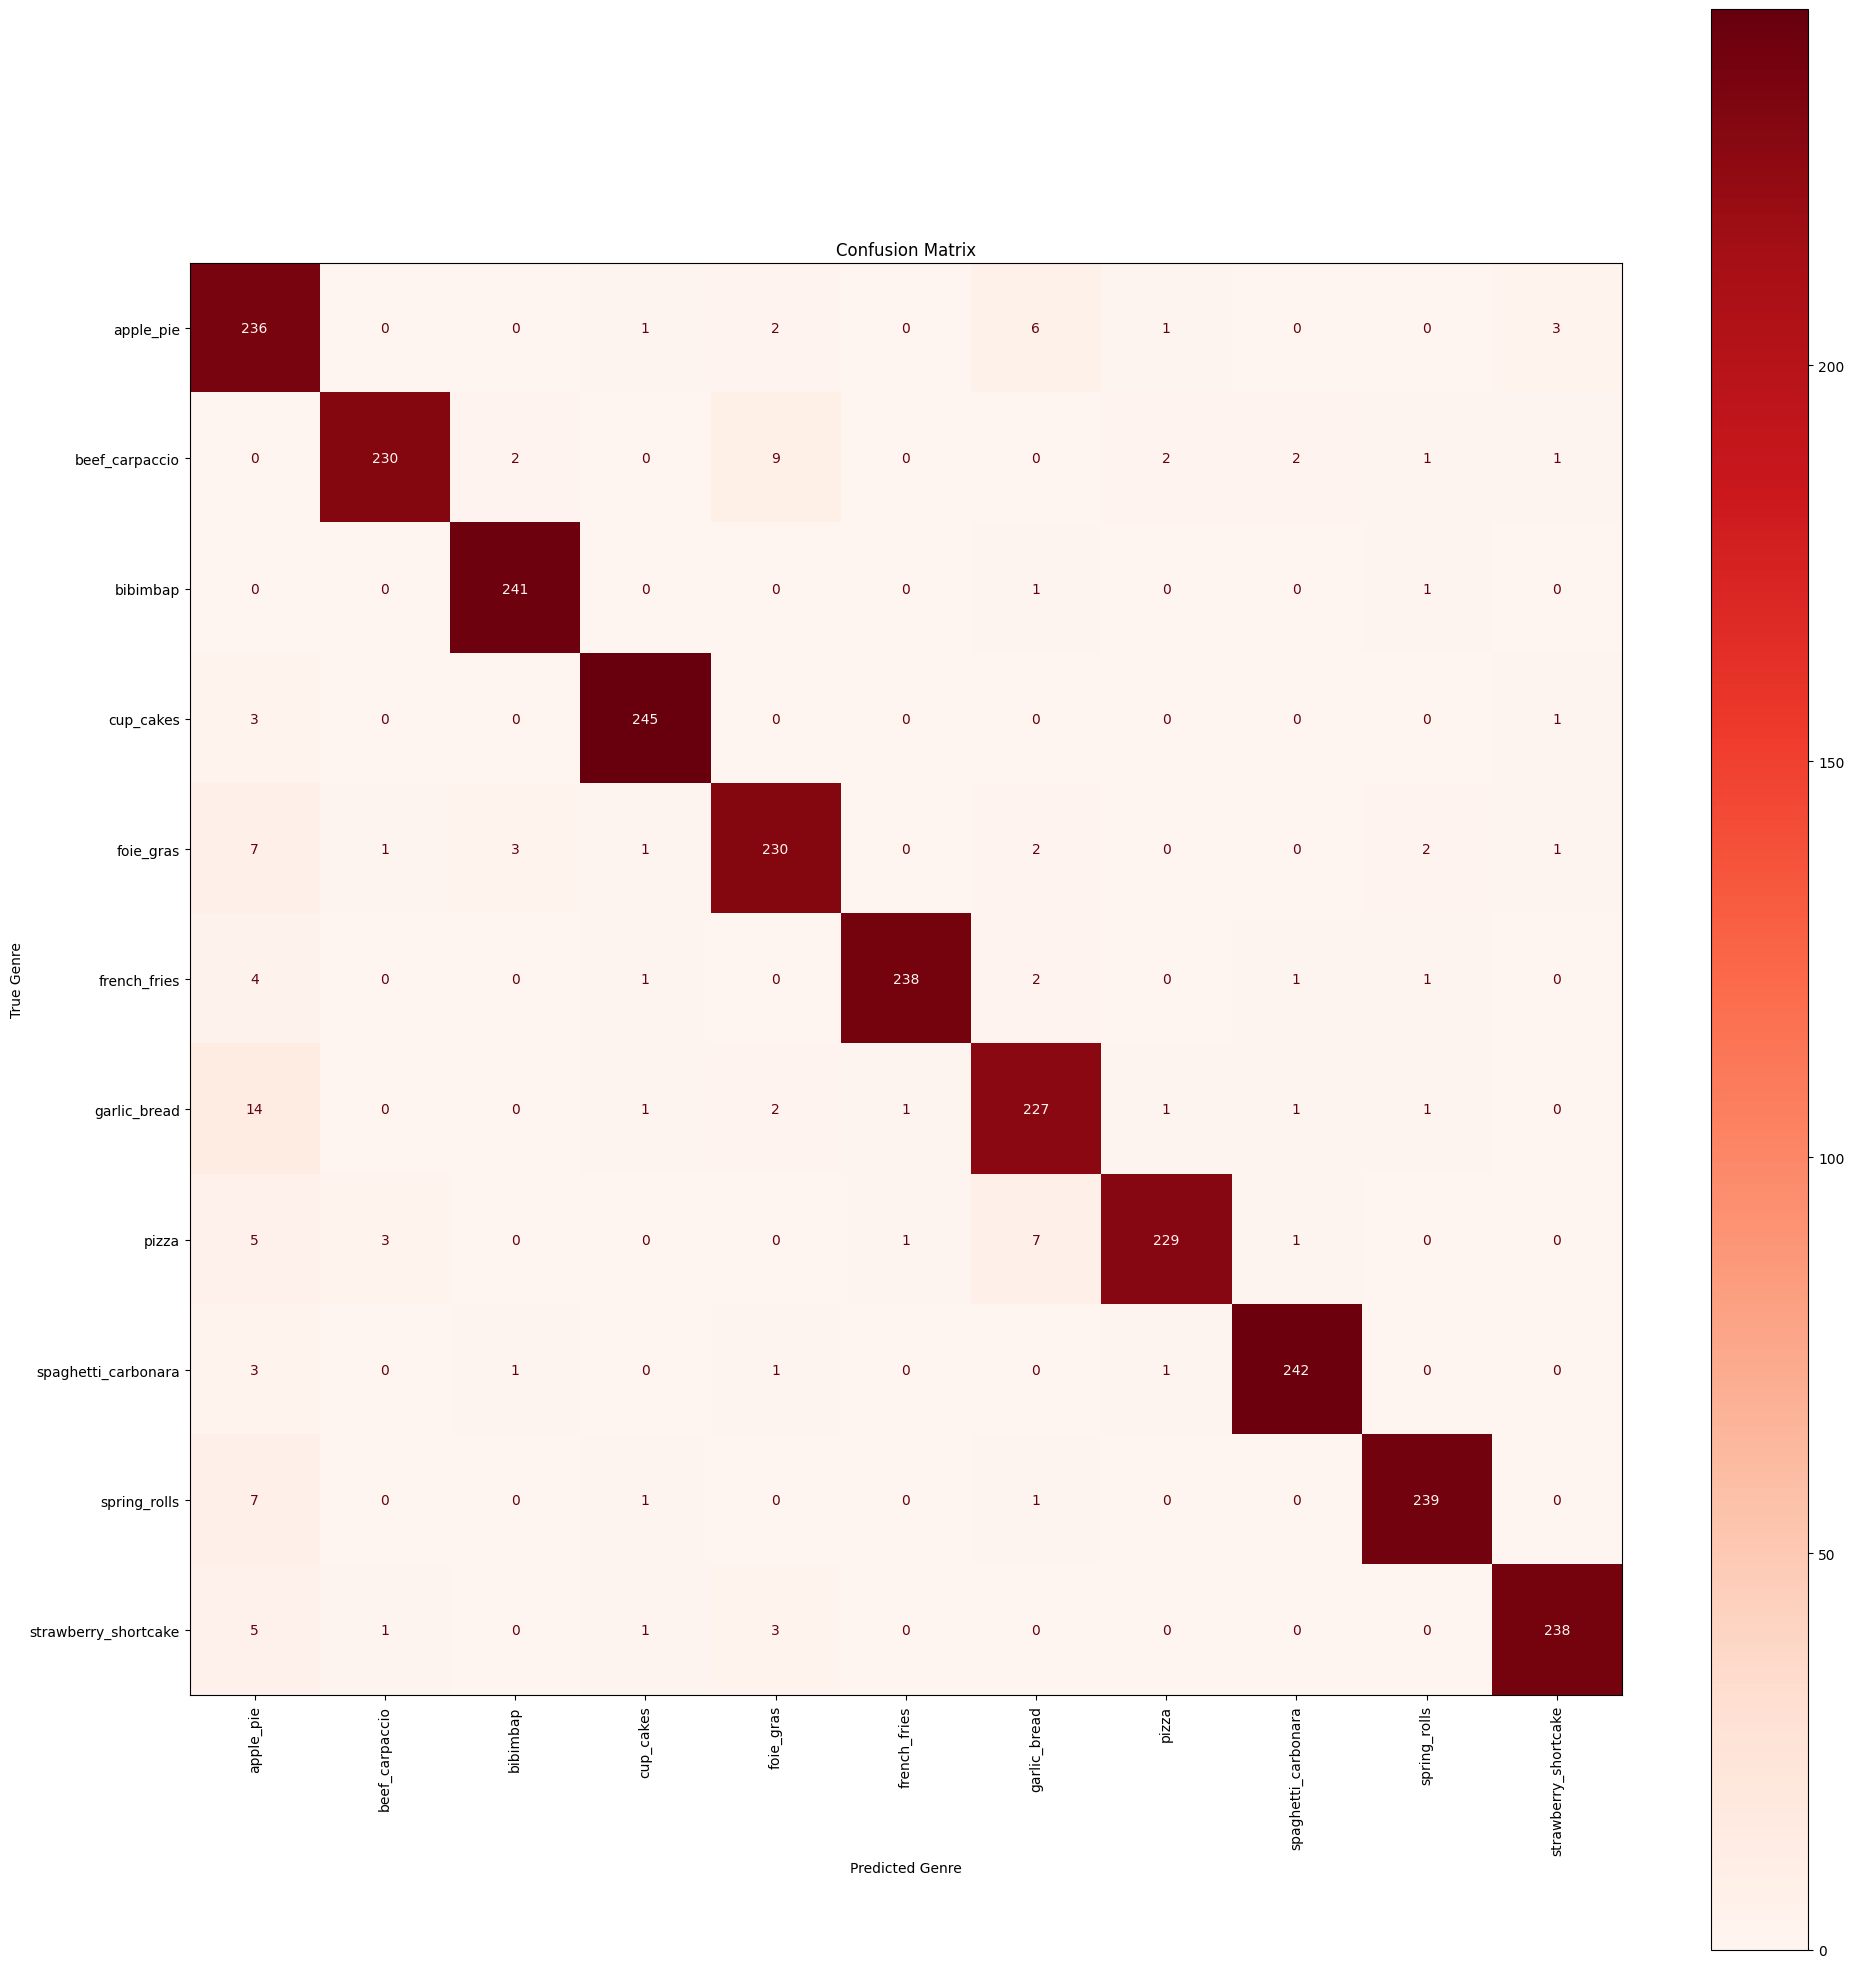

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_11)

# Adjust figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

## Training with 101 categories

### Entire data split into train and validation

In [ ]:
# batch_size = 128
# image_size = (224, 224)
# selected_folders = os.listdir(root_dir)
# num_classes = len(selected_folders)

# # Create an ImageDataGenerator for data augmentation and preprocessing
# data_generator = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2
#     # rotation_range=30,
#     # shear_range=0.3,
#     # horizontal_flip=True,
#     # width_shift_range=0.1,
#     # height_shift_range=0.1,
#     # zoom_range=0.25,
# )

# train_generator = data_generator.flow_from_directory(
#     root_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# validation_generator = data_generator.flow_from_directory(
#     root_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# train_steps_per_epoch = train_generator.samples // batch_size
# validation_steps_per_epoch = validation_generator.samples // batch_size

Found 75000 images belonging to 101 classes.
Found 0 images belonging to 101 classes.


### Separate train and test folders. Train split into train and validation, test directory used for evaluation

### CNN

In [14]:
# Try 32, 128
batch_size = 32
epochs = 10
image_size = (224, 224)

# Split the data into train, validation, and test sets
train_dir = "/content/kmader/train"
test_dir = "/content/kmader/test"
selected_folders = os.listdir(train_dir)
num_classes = len(selected_folders)
print("Number of classes", num_classes)

# Create an ImageDataGenerator for data augmentation and preprocessing
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_data_generator = ImageDataGenerator(
    rescale=1./255
)

# Generate the train set
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate the test set
validation_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

train_steps_per_epoch = train_generator.samples // batch_size
validation_steps_per_epoch = validation_generator.samples // batch_size

Number of classes 101
Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [15]:
class_map_101 = train_generator.class_indices
class_labels_101 = list(class_map_101.keys())
print(class_map_101)
print("")
print(class_labels_101)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

To visualize class imbalances

In [16]:
# # Get the class indices
# class_indices = test_generator.class_indices

# # Get the class frequencies
# class_frequencies = test_generator.classes
# class_counts = [0] * len(class_indices)
# for class_index in class_frequencies:
#     class_counts[class_index] += 1

# # Plot the class distribution
# class_labels = list(class_indices.keys())
# plt.figure(figsize=(12, 6))
# plt.bar(class_labels, class_counts)
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.title('Class Distribution')
# plt.xticks(rotation=90)
# plt.show()

In [17]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.005)))

In [18]:
# # Try multiple learning rates - 0.1, 0.01, 1e-3, 1e-4, 1e-5, 3e-4
# opt = tf.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
# opt = tf.optimizers.RMSprop(learning_rate=1e-3)
# opt = tf.optimizers.Adam(learning_rate=1e-3)
opt = tfa.optimizers.RectifiedAdam(learning_rate = 1e-4)
# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# tf.keras.utils.plot_model(model)

In [ ]:
# Define early stopping and reduce LR callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=True)

# Define the path where you want to save the model checkpoints
checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_10epochs_32batch_rectifiedadam/model_checkpoints/ckpt_{epoch:02d}.h5'

# Create a ModelCheckpoint callback to save the model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor='val_loss',
                                                      mode='min',
                                                      verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch,
    epochs=epochs,
    callbacks = [early_stopping, lr_schedule, model_checkpoint]
)

Epoch 1/10
2367/2367 [==============================] - ETA: 0s - loss: 4.8129 - accuracy: 0.0354
Epoch 1: val_loss improved from inf to 4.24908, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_10epochs_32batch_rectifiedadam/model_checkpoints/ckpt_01.h5
2367/2367 [==============================] - 963s 402ms/step - loss: 4.8129 - accuracy: 0.0354 - val_loss: 4.2491 - val_accuracy: 0.0901 - lr: 1.0000e-04
Epoch 2/10
2367/2367 [==============================] - ETA: 0s - loss: 4.2171 - accuracy: 0.0835
Epoch 2: val_loss improved from 4.24908 to 3.96536, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_10epochs_32batch_rectifiedadam/model_checkpoints/ckpt_02.h5
2367/2367 [==============================] - 945s 399ms/step - loss: 4.2171 - accuracy: 0.0835 - val_loss: 3.9654 - val_accuracy: 0.1233 - lr: 1.0000e-04
Epoch 3/10
2367/2367 [==============================] - ETA: 0s - loss: 4.0055 - accuracy: 0.1135
Epoch 3: val_loss improved from 3.96536 

To start training from a saved checkpoint

In [ ]:
checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_32_10_rectifiedadam.h5'
model.load_weights(checkpoint_path)

opt = tfa.optimizers.RectifiedAdam(learning_rate = 1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce LR callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=True)

# Define the path where you want to save the model checkpoints
checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_20_32_rectifiedadam/model_checkpoints/ckpt_{epoch:02d}.h5'

# Create a ModelCheckpoint callback to save the model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor='val_loss',
                                                      mode='min',
                                                      verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch,
    epochs=epochs,
    callbacks = [early_stopping, lr_schedule, model_checkpoint]
)

# # Set the number of epochs to train (including the 8th epoch)
# epochs_to_train = 20
# initial_epoch = 10

# # Continue training from the 8th epoch and run the remaining epochs
# history = model.fit(train_generator,
#                     steps_per_epoch=train_steps_per_epoch,
#                     validation_data=validation_generator,
#                     validation_steps=validation_steps_per_epoch,
#                     epochs=epochs_to_train,
#                     initial_epoch=initial_epoch,
#                     callbacks=[lr_schedule, model_checkpoint],
#                     verbose=1
#                     )

Epoch 1/10
2367/2367 [==============================] - ETA: 0s - loss: 3.2295 - accuracy: 0.2408
Epoch 1: val_loss improved from inf to 3.12126, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_20_32_rectifiedadam/model_checkpoints/ckpt_01.h5
2367/2367 [==============================] - 7024s 3s/step - loss: 3.2295 - accuracy: 0.2408 - val_loss: 3.1213 - val_accuracy: 0.2640 - lr: 1.0000e-04
Epoch 2/10
2367/2367 [==============================] - ETA: 0s - loss: 3.2189 - accuracy: 0.2448
Epoch 2: val_loss did not improve from 3.12126
2367/2367 [==============================] - 6929s 3s/step - loss: 3.2189 - accuracy: 0.2448 - val_loss: 3.1859 - val_accuracy: 0.2507 - lr: 1.0000e-04
Epoch 3/10
2367/2367 [==============================] - ETA: 0s - loss: 3.1885 - accuracy: 0.2506
Epoch 3: val_loss improved from 3.12126 to 3.08745, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_20_32_rectifiedadam/model_checkpoints/ckpt_03.h5
2367/2367 [========

In [ ]:
# Save the model as an H5 file
model.save('/content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_32_20_rectifiedadam_final.h5')

In [ ]:
test_error, test_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test accuracy: ", test_accuracy)

To test prediction on one image using saved model

In [22]:
model = load_model('/content/gdrive/My Drive/DS 5500/Phase 2/cnn/cnn_101_32_10_rectifiedadam.h5')
# sample_image_path = "/content/kmader/test/apple_pie/1011328.jpg"
sample_image_path = "/content/kmader/test/apple_pie/1011328.jpg"
# class_indices = {'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 51, 'gyoza': 52, 'hamburger': 53, 'hot_and_sour_soup': 54, 'hot_dog': 55, 'huevos_rancheros': 56, 'hummus': 57, 'ice_cream': 58, 'lasagna': 59, 'lobster_bisque': 60, 'lobster_roll_sandwich': 61, 'macaroni_and_cheese': 62, 'macarons': 63, 'miso_soup': 64, 'mussels': 65, 'nachos': 66, 'omelette': 67, 'onion_rings': 68, 'oysters': 69, 'pad_thai': 70, 'paella': 71, 'pancakes': 72, 'panna_cotta': 73, 'peking_duck': 74, 'pho': 75, 'pizza': 76, 'pork_chop': 77, 'poutine': 78, 'prime_rib': 79, 'pulled_pork_sandwich': 80, 'ramen': 81, 'ravioli': 82, 'red_velvet_cake': 83, 'risotto': 84, 'samosa': 85, 'sashimi': 86, 'scallops': 87, 'seaweed_salad': 88, 'shrimp_and_grits': 89, 'spaghetti_bolognese': 90, 'spaghetti_carbonara': 91, 'spring_rolls': 92, 'steak': 93, 'strawberry_shortcake': 94, 'sushi': 95, 'tacos': 96, 'takoyaki': 97, 'tiramisu': 98, 'tuna_tartare': 99, 'waffles': 100}
# class_labels = list(class_indices.keys())

# Load and preprocess the image
image = load_img(sample_image_path, target_size=(224, 224))
image = img_to_array(image)
image = image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape of the model
image = np.expand_dims(image, axis=0)

# Make predictions
predictions = model.predict(image)

# Get the predicted label
predicted_label = np.argmax(predictions[0])

# Print the predicted label
print("Predicted class and label:", predicted_label, class_labels_101[predicted_label], class_map_101[class_labels_101[predicted_label]])

1/1 [==============================] - 0s 104ms/step
Predicted class and label: 2 baklava 2


Accuracy & Loss Curves

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

Classification Report

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

# Continue with classification_report and print the report
category_names = list(train_generator.class_indices.keys())

report = classification_report(y_true_classes, y_pred_classes, target_names=category_names, zero_division=0)
# Print the classification report
print(report)

1/1 [==============================] - 0s 32ms/step
                         precision    recall  f1-score   support

              apple_pie       0.12      0.08      0.10       250
         baby_back_ribs       0.16      0.44      0.23       250
                baklava       0.18      0.26      0.21       250
         beef_carpaccio       0.25      0.68      0.37       250
           beef_tartare       0.13      0.10      0.11       250
             beet_salad       0.31      0.22      0.26       250
               beignets       0.24      0.69      0.36       250
               bibimbap       0.31      0.56      0.40       250
          bread_pudding       0.17      0.10      0.12       250
      breakfast_burrito       0.07      0.01      0.01       250
             bruschetta       0.19      0.09      0.12       250
           caesar_salad       0.33      0.36      0.35       250
                cannoli       0.18      0.26      0.22       250
          caprese_salad       0.39   

Confusion Matrix

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

1/1 [==============================] - 0s 29ms/step


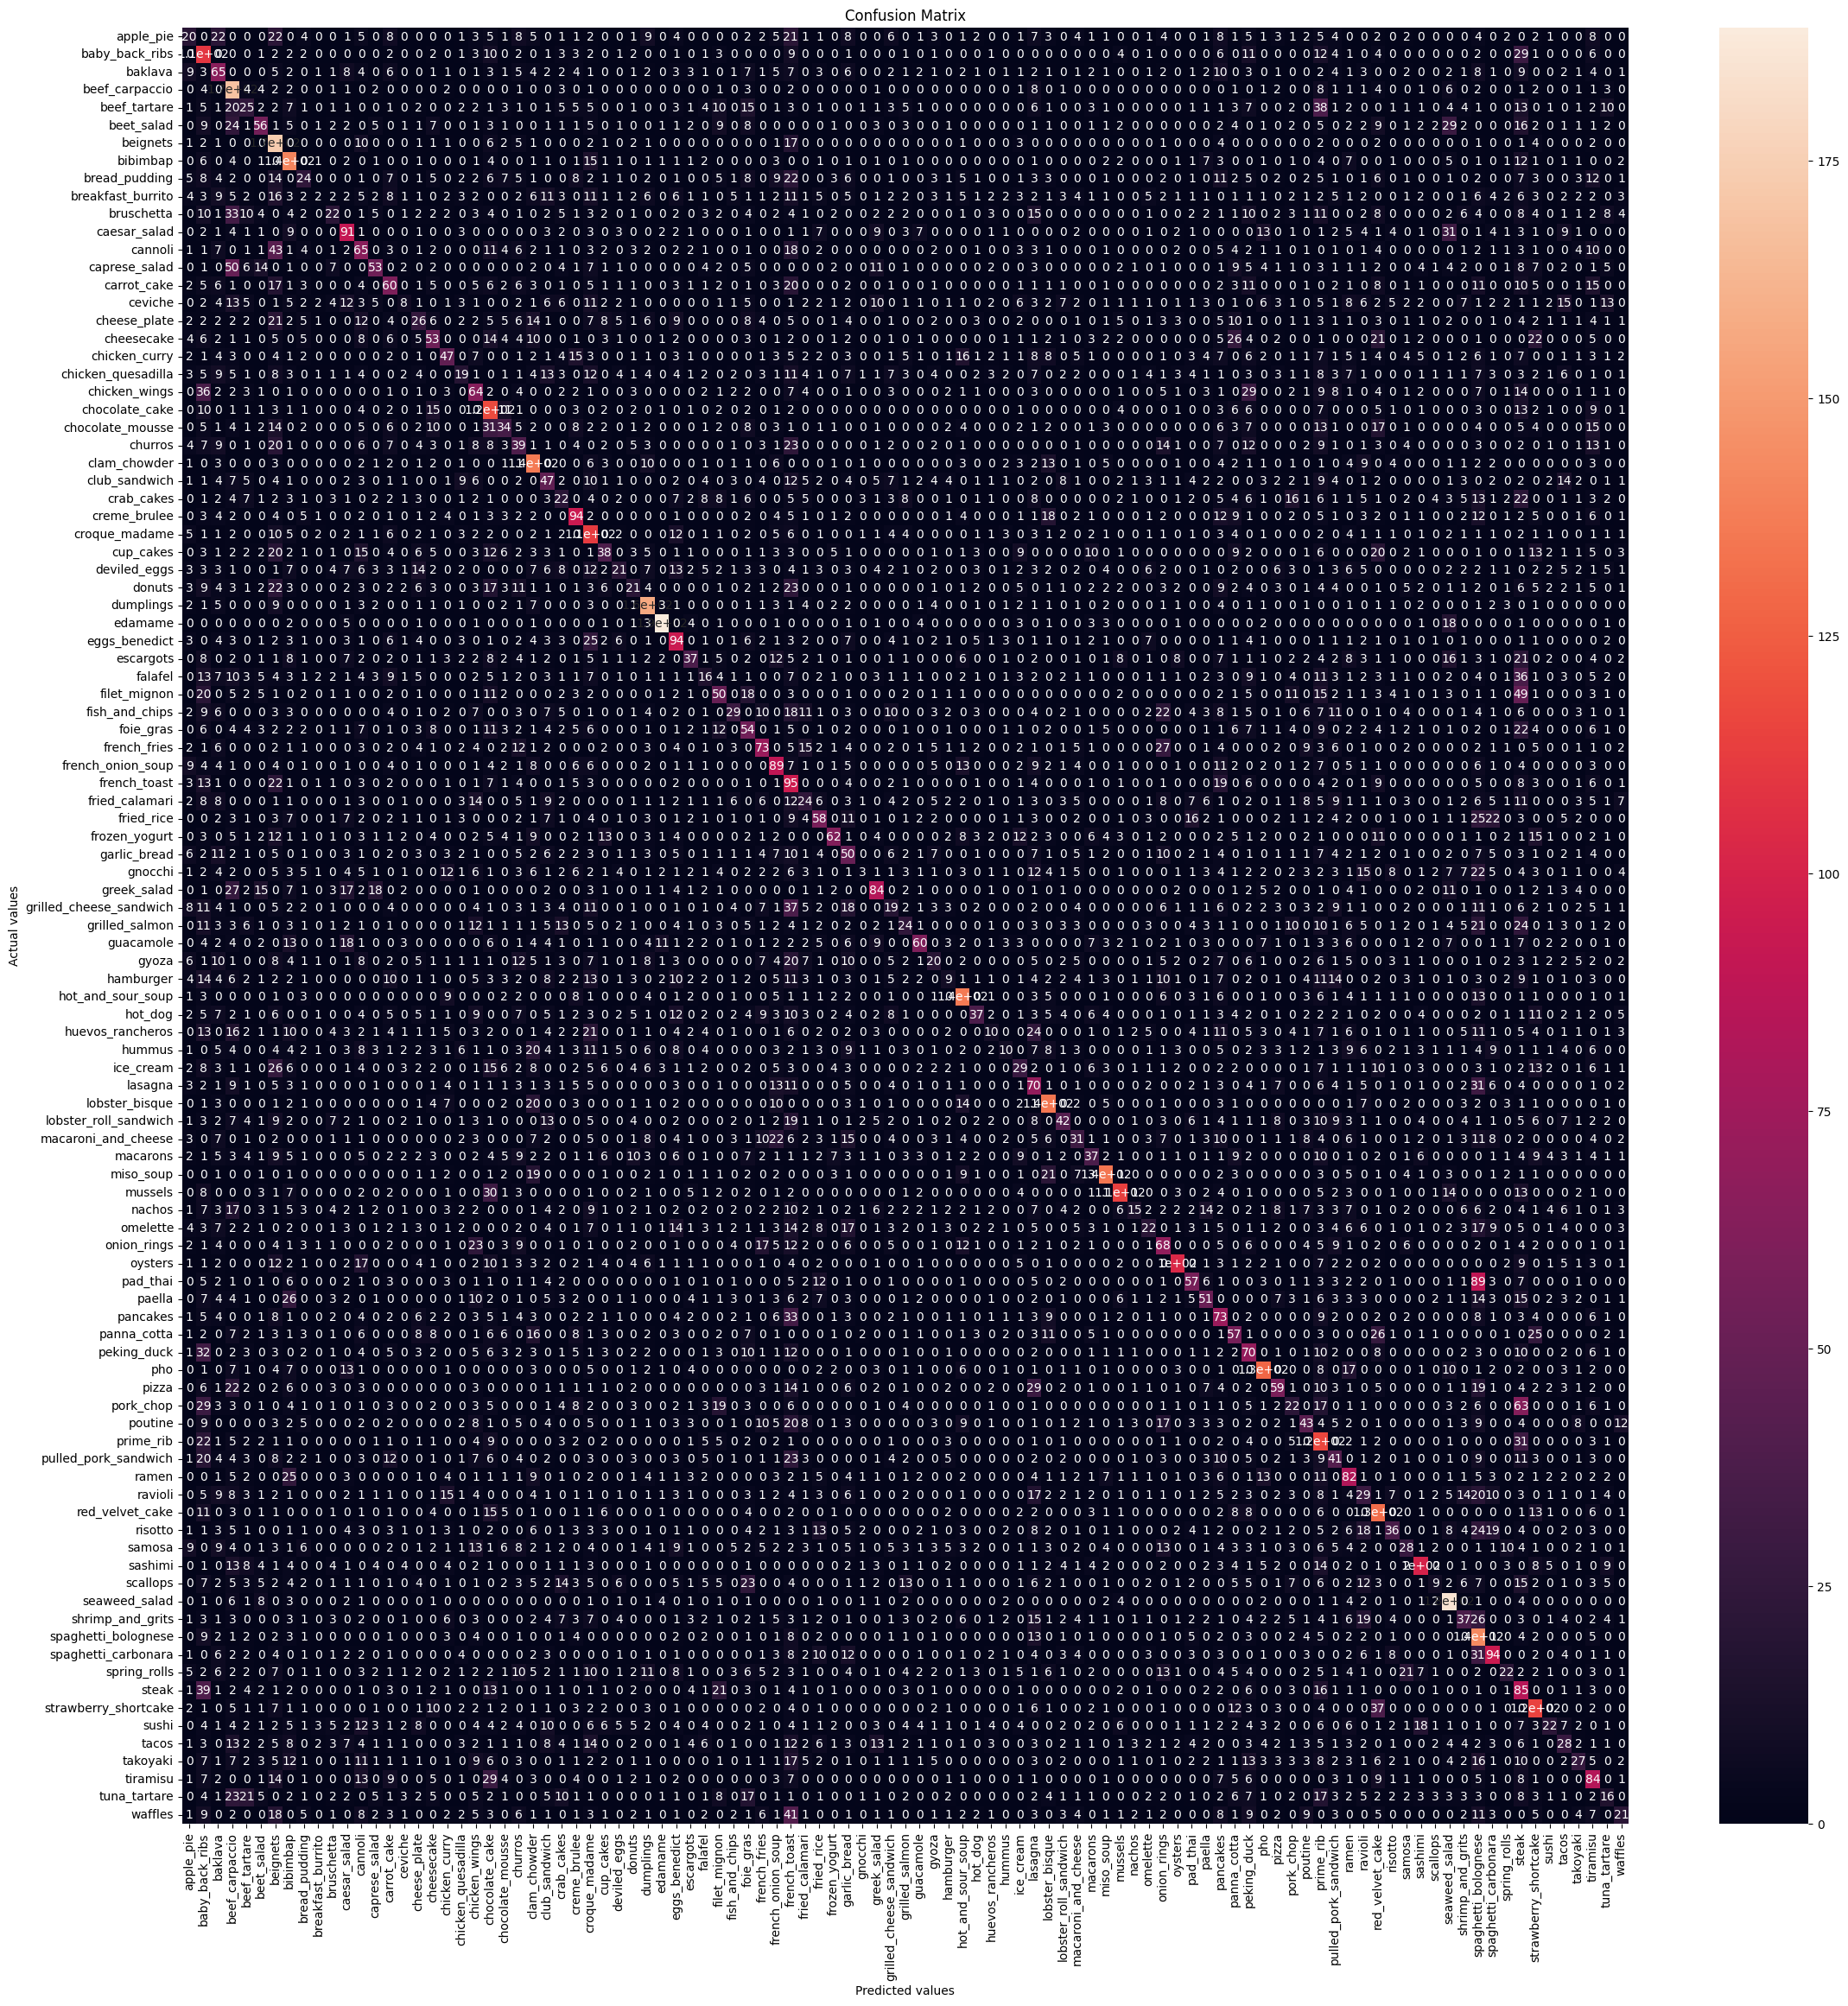

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=category_names, columns = category_names)
plt.figure(figsize=(27, 27))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

### InceptionV3

In [23]:
# K.clear_session()
batch_size = 32
epochs = 20
image_size = (299, 299)

# Split the data into train, validation, and test sets
train_dir = "/content/kmader/train"
test_dir = "/content/kmader/test"
selected_folders = os.listdir(train_dir)
num_classes = len(selected_folders)
print("Number of classes", num_classes)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

# Generate the train set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate the validation set
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

train_steps_per_epoch = train_generator.samples // batch_size
validation_steps_per_epoch = validation_generator.samples // batch_size

Number of classes 101
Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [24]:
class_map_101 = train_generator.class_indices
class_labels_101 = list(class_map_101.keys())
print(class_map_101)
print("")
print(class_labels_101)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [ ]:
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = inceptionv3.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

predictions = Dense(num_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inceptionv3.input, outputs=predictions)

learning_rate = 1e-4
weight_decay = 1e-4
# optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)
# optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

# Define the path where you want to save the model checkpoints
checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/inception_v3/inceptionv3_101_32_20_rectifiedadam/model_checkpoints/ckpt_{epoch:02d}.h5'

# Create a ModelCheckpoint callback to save the model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor='val_loss',
                                                      mode='min',
                                                      verbose=1)

# Define early stopping and reduce LR callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps_per_epoch,
                    epochs=epochs,
                    callbacks=[early_stopping, lr_schedule, model_checkpoint],
                    verbose=1
                    )

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
2367/2367 [==============================] - ETA: 0s - loss: 3.6507 - accuracy: 0.4527
Epoch 1: val_loss improved from inf to 2.72308, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/inception_v3/inceptionv3_101_32_20_rectifiedadam/model_checkpoints/ckpt_01.h5
2367/2367 [==============================] - 1827s 757ms/step - loss: 3.6507 - accuracy: 0.4527 - val_loss: 2.7231 - val_accuracy: 0.6985 - lr: 1.0000e-04
Epoch 2/20
2367/2367 [==============================] - ETA: 0s - loss: 2.7267 - accuracy: 0.6948
Epoch 2: val_loss improved from 2.72308 to 2.45085, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/inception_v3/inceptionv3_101_32_20_rectifiedadam/model_checkpoints/ckpt_02.h5
2367/2367 [==============================] - 1830s 773ms/step - loss: 2.7267 - accuracy: 0.6948 - val_loss: 2.4509 - val_accuracy: 0.7478 - lr: 1.0000e-04
Epoch 3/20
2367/2367 [==============================] - ETA

In [ ]:
model.save('/content/gdrive/My Drive/DS 5500/Phase 2/inception_v3/inceptionv3_101_32_10_rectified.h5')
files.download('/content/gdrive/My Drive/DS 5500/Phase 2/inception_v3/inceptionv3_101_32_10_rectified.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To start training from a particular saved checkpoint

In [25]:
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = inceptionv3.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

predictions = Dense(num_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inceptionv3.input, outputs=predictions)

checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/inception_v3/ckpt_10.h5'
model.load_weights(checkpoint_path)

learning_rate = 1e-4
weight_decay = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

# # Define the path where you want to save the model checkpoints for the remaining epochs
# checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/inception_v3/inceptionv3_101_10epochs_32batch/model_checkpoints/ckpt_{epoch:02d}.h5'
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                       save_weights_only=True,
#                                                       save_best_only=True,
#                                                       monitor='val_loss',
#                                                       mode='min',
#                                                       verbose=1)

# # Define early stopping and reduce LR callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
# lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# # Set the number of epochs to train (including the 8th epoch)
# epochs_to_train = 10
# initial_epoch = 7

# # Continue training from the 8th epoch and run the remaining epochs
# history = model.fit(train_generator,
#                     steps_per_epoch=train_steps_per_epoch,
#                     validation_data=validation_generator,
#                     validation_steps=validation_steps_per_epoch,
#                     epochs=epochs_to_train,
#                     initial_epoch=initial_epoch,
#                     callbacks=[lr_schedule, model_checkpoint],
#                     verbose=1
#                     )

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
test_error, test_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test accuracy: ", test_accuracy)

790/790 [==============================] - 4162s 5s/step - loss: 1.8650 - accuracy: 0.8613
Test accuracy:  0.8612673282623291


Predicting label for one picture

In [ ]:
model = load_model('/content/gdrive/My Drive/DS 5500/Phase 2/inceptionv3_101.h5')
sample_image_path = "/content/kmader/test/apple_pie/101251.jpg"

class_label_mapping = {'apple_pie': 'Apple pie', 'baby_back_ribs': 'Baby back ribs', 'baklava': 'Baklava', 'beef_carpaccio': 'Beef carpaccio', 'beef_tartare': 'Beef tartare', 'beet_salad': 'Beet salad', 'beignets': 'Beignets', 'bibimbap': 'Bibimbap', 'bread_pudding': 'Bread pudding', 'breakfast_burrito': 'Breakfast burrito', 'bruschetta': 'Bruschetta', 'caesar_salad': 'Caesar salad', 'cannoli': 'Cannoli', 'caprese_salad': 'Caprese salad', 'carrot_cake': 'Carrot cake', 'ceviche': 'Ceviche', 'cheesecake': 'Cheesecake', 'cheese_plate': 'Cheese plate', 'chicken_curry': 'Chicken curry', 'chicken_quesadilla': 'Chicken quesadilla', 'chicken_wings': 'Chicken wings', 'chocolate_cake': 'Chocolate cake', 'chocolate_mousse': 'Chocolate mousse', 'churros': 'Churros', 'clam_chowder': 'Clam chowder', 'club_sandwich': 'Club sandwich', 'crab_cakes': 'Crab cakes', 'creme_brulee': 'Creme brulee', 'croque_madame': 'Croque madame', 'cup_cakes': 'Cup cakes', 'deviled_eggs': 'Deviled eggs', 'donuts': 'Donuts', 'dumplings': 'Dumplings', 'edamame': 'Edamame', 'eggs_benedict': 'Eggs benedict', 'escargots': 'Escargots', 'falafel': 'Falafel', 'filet_mignon': 'Filet mignon', 'fish_and_chips': 'Fish and chips', 'foie_gras': 'Foie gras', 'french_fries': 'French fries', 'french_onion_soup': 'French onion soup', 'french_toast': 'French toast', 'fried_calamari': 'Fried calamari', 'fried_rice': 'Fried rice', 'frozen_yogurt': 'Frozen yogurt', 'garlic_bread': 'Garlic bread', 'gnocchi': 'Gnocchi', 'greek_salad': 'Greek salad', 'grilled_cheese_sandwich': 'Grilled cheese sandwich', 'grilled_salmon': 'Grilled salmon', 'guacamole': 'Guacamole', 'gyoza': 'Gyoza', 'hamburger': 'Hamburger', 'hot_and_sour_soup': 'Hot and sour soup', 'hot_dog': 'Hot dog', 'huevos_rancheros': 'Huevos rancheros', 'hummus': 'Hummus', 'ice_cream': 'Ice cream', 'lasagna': 'Lasagna', 'lobster_bisque': 'Lobster bisque', 'lobster_roll_sandwich': 'Lobster roll sandwich', 'macaroni_and_cheese': 'Macaroni and cheese', 'macarons': 'Macarons', 'miso_soup': 'Miso soup', 'mussels': 'Mussels', 'nachos': 'Nachos', 'omelette': 'Omelette', 'onion_rings': 'Onion rings', 'oysters': 'Oysters', 'pad_thai': 'Pad thai', 'paella': 'Paella', 'pancakes': 'Pancakes', 'panna_cotta': 'Panna cotta', 'peking_duck': 'Peking duck', 'pho': 'Pho', 'pizza': 'Pizza', 'pork_chop': 'Pork chop', 'poutine': 'Poutine', 'prime_rib': 'Prime rib', 'pulled_pork_sandwich': 'Pulled pork sandwich', 'ramen': 'Ramen', 'ravioli': 'Ravioli', 'red_velvet_cake': 'Red velvet cake', 'risotto': 'Risotto', 'samosa': 'Samosa', 'sashimi': 'Sashimi', 'scallops': 'Scallops', 'seaweed_salad': 'Seaweed salad', 'shrimp_and_grits': 'Shrimp and grits', 'spaghetti_bolognese': 'Spaghetti bolognese', 'spaghetti_carbonara': 'Spaghetti carbonara', 'spring_rolls': 'Spring rolls', 'steak': 'Steak', 'strawberry_shortcake': 'Strawberry shortcake', 'sushi': 'Sushi', 'tacos': 'Tacos', 'takoyaki': 'Takoyaki', 'tiramisu': 'Tiramisu', 'tuna_tartare': 'Tuna tartare', 'waffles': 'Waffles'}
class_map_101 = {'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 51, 'gyoza': 52, 'hamburger': 53, 'hot_and_sour_soup': 54, 'hot_dog': 55, 'huevos_rancheros': 56, 'hummus': 57, 'ice_cream': 58, 'lasagna': 59, 'lobster_bisque': 60, 'lobster_roll_sandwich': 61, 'macaroni_and_cheese': 62, 'macarons': 63, 'miso_soup': 64, 'mussels': 65, 'nachos': 66, 'omelette': 67, 'onion_rings': 68, 'oysters': 69, 'pad_thai': 70, 'paella': 71, 'pancakes': 72, 'panna_cotta': 73, 'peking_duck': 74, 'pho': 75, 'pizza': 76, 'pork_chop': 77, 'poutine': 78, 'prime_rib': 79, 'pulled_pork_sandwich': 80, 'ramen': 81, 'ravioli': 82, 'red_velvet_cake': 83, 'risotto': 84, 'samosa': 85, 'sashimi': 86, 'scallops': 87, 'seaweed_salad': 88, 'shrimp_and_grits': 89, 'spaghetti_bolognese': 90, 'spaghetti_carbonara': 91, 'spring_rolls': 92, 'steak': 93, 'strawberry_shortcake': 94, 'sushi': 95, 'tacos': 96, 'takoyaki': 97, 'tiramisu': 98, 'tuna_tartare': 99, 'waffles': 100}
class_labels_101 = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']

# Load and preprocess the image
image = load_img(sample_image_path, target_size=(299, 299))
# plt.imshow(image)
image = img_to_array(image)
image = image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape of the model
image = np.expand_dims(image, axis=0)

# Make predictions
predictions = model.predict(image)

# Get the predicted label
predicted_label = np.argmax(predictions[0])

# Print the predicted label
print("Predicted class and label:", class_labels_101[predicted_label], class_label_mapping[class_labels_101[predicted_label]])

1/1 [==============================] - 1s 1s/step
Predicted class and label: apple_pie Apple pie


Accuracy & Loss Curves

In [34]:
# # Plotting accuracy
# plt.figure(figsize=(14, 6))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'])

# # Plotting loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'])

# plt.show()

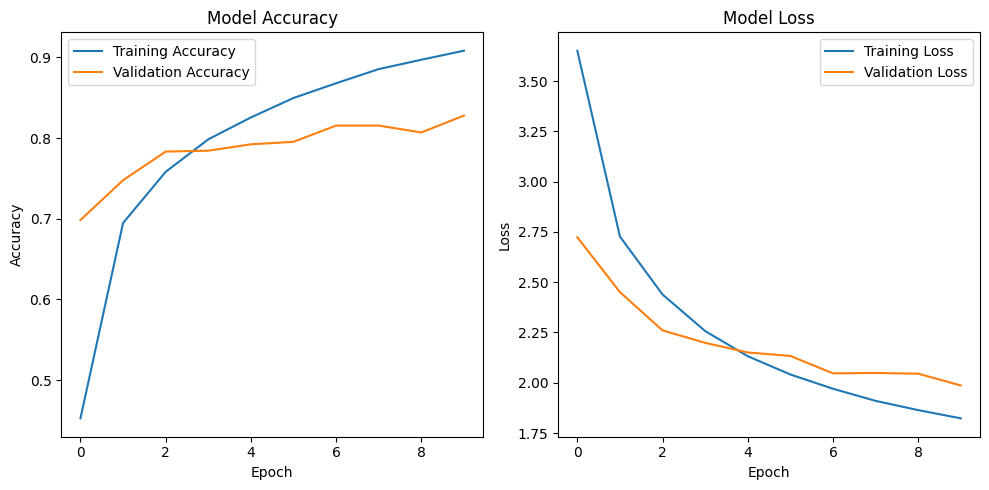

In [32]:
# Define the training history
history = {
    'loss': [3.6507, 2.7267, 2.4388, 2.2570, 2.1320, 2.0411, 1.9702, 1.9100, 1.8639, 1.8231],
    'accuracy': [0.4527, 0.6948, 0.7582, 0.7985, 0.8256, 0.8497, 0.8680, 0.8855, 0.8971, 0.9083],
    'val_loss': [2.72308, 2.45085, 2.26020, 2.19846, 2.15062, 2.13331, 2.04677, 2.0486, 2.04516, 1.98661],
    'val_accuracy': [0.6985, 0.7478, 0.7833, 0.7844, 0.7923, 0.7954, 0.8155, 0.8155, 0.8070, 0.8279]
}

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# # Lists for training and validation loss
# train_loss = [3.6507, 2.7267, 2.4388, 2.2570, 2.1320, 2.0411, 1.9702, 1.9100, 1.8639, 1.8231, 1.7888, 1.7598, 1.7377, 1.6340, 1.5999, 1.5823, 1.5717, 1.5606, 1.5530, 1.5385]
# val_loss = [2.7231, 2.4509, 2.2602, 2.1985, 2.1506, 2.1333, 2.0468, 2.0486, 2.0452, 1.9866, 2.0309, 2.0145, 1.9950, 1.8841, 1.8893, 1.8764, 1.8852, 1.8927, 1.8951, 1.8651]

# # Lists for training and validation accuracy
# train_accuracy = [0.4527, 0.6948, 0.7582, 0.7985, 0.8256, 0.8497, 0.8680, 0.8855, 0.8971, 0.9083, 0.9191, 0.9267, 0.9323, 0.9686, 0.9791, 0.9843, 0.9863, 0.9885, 0.9900, 0.9932]
# val_accuracy = [0.6985, 0.7478, 0.7833, 0.7844, 0.7923, 0.7954, 0.8155, 0.8155, 0.8070, 0.8279, 0.8097, 0.8111, 0.8178, 0.8545, 0.8520, 0.8563, 0.8558, 0.8524, 0.8500, 0.8613]

# # Plotting accuracy
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')

# # Plotting loss
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')

# plt.show()


Classification Report

In [26]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

# Continue with classification_report and print the report
category_names = list(train_generator.class_indices.keys())

report = classification_report(y_true_classes, y_pred_classes, target_names=category_names, zero_division=0)
# Print the classification report
print(report)

1/1 [==============================] - 1s 549ms/step
                         precision    recall  f1-score   support

              apple_pie       0.69      0.60      0.64       250
         baby_back_ribs       0.86      0.84      0.85       250
                baklava       0.94      0.88      0.90       250
         beef_carpaccio       0.83      0.90      0.87       250
           beef_tartare       0.85      0.76      0.80       250
             beet_salad       0.64      0.80      0.71       250
               beignets       0.92      0.87      0.89       250
               bibimbap       0.93      0.90      0.91       250
          bread_pudding       0.62      0.69      0.65       250
      breakfast_burrito       0.67      0.81      0.73       250
             bruschetta       0.80      0.73      0.77       250
           caesar_salad       0.95      0.80      0.87       250
                cannoli       0.97      0.87      0.92       250
          caprese_salad       0.85  

Confusion Matrix

In [ ]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

1/1 [==============================] - 5s 5s/step


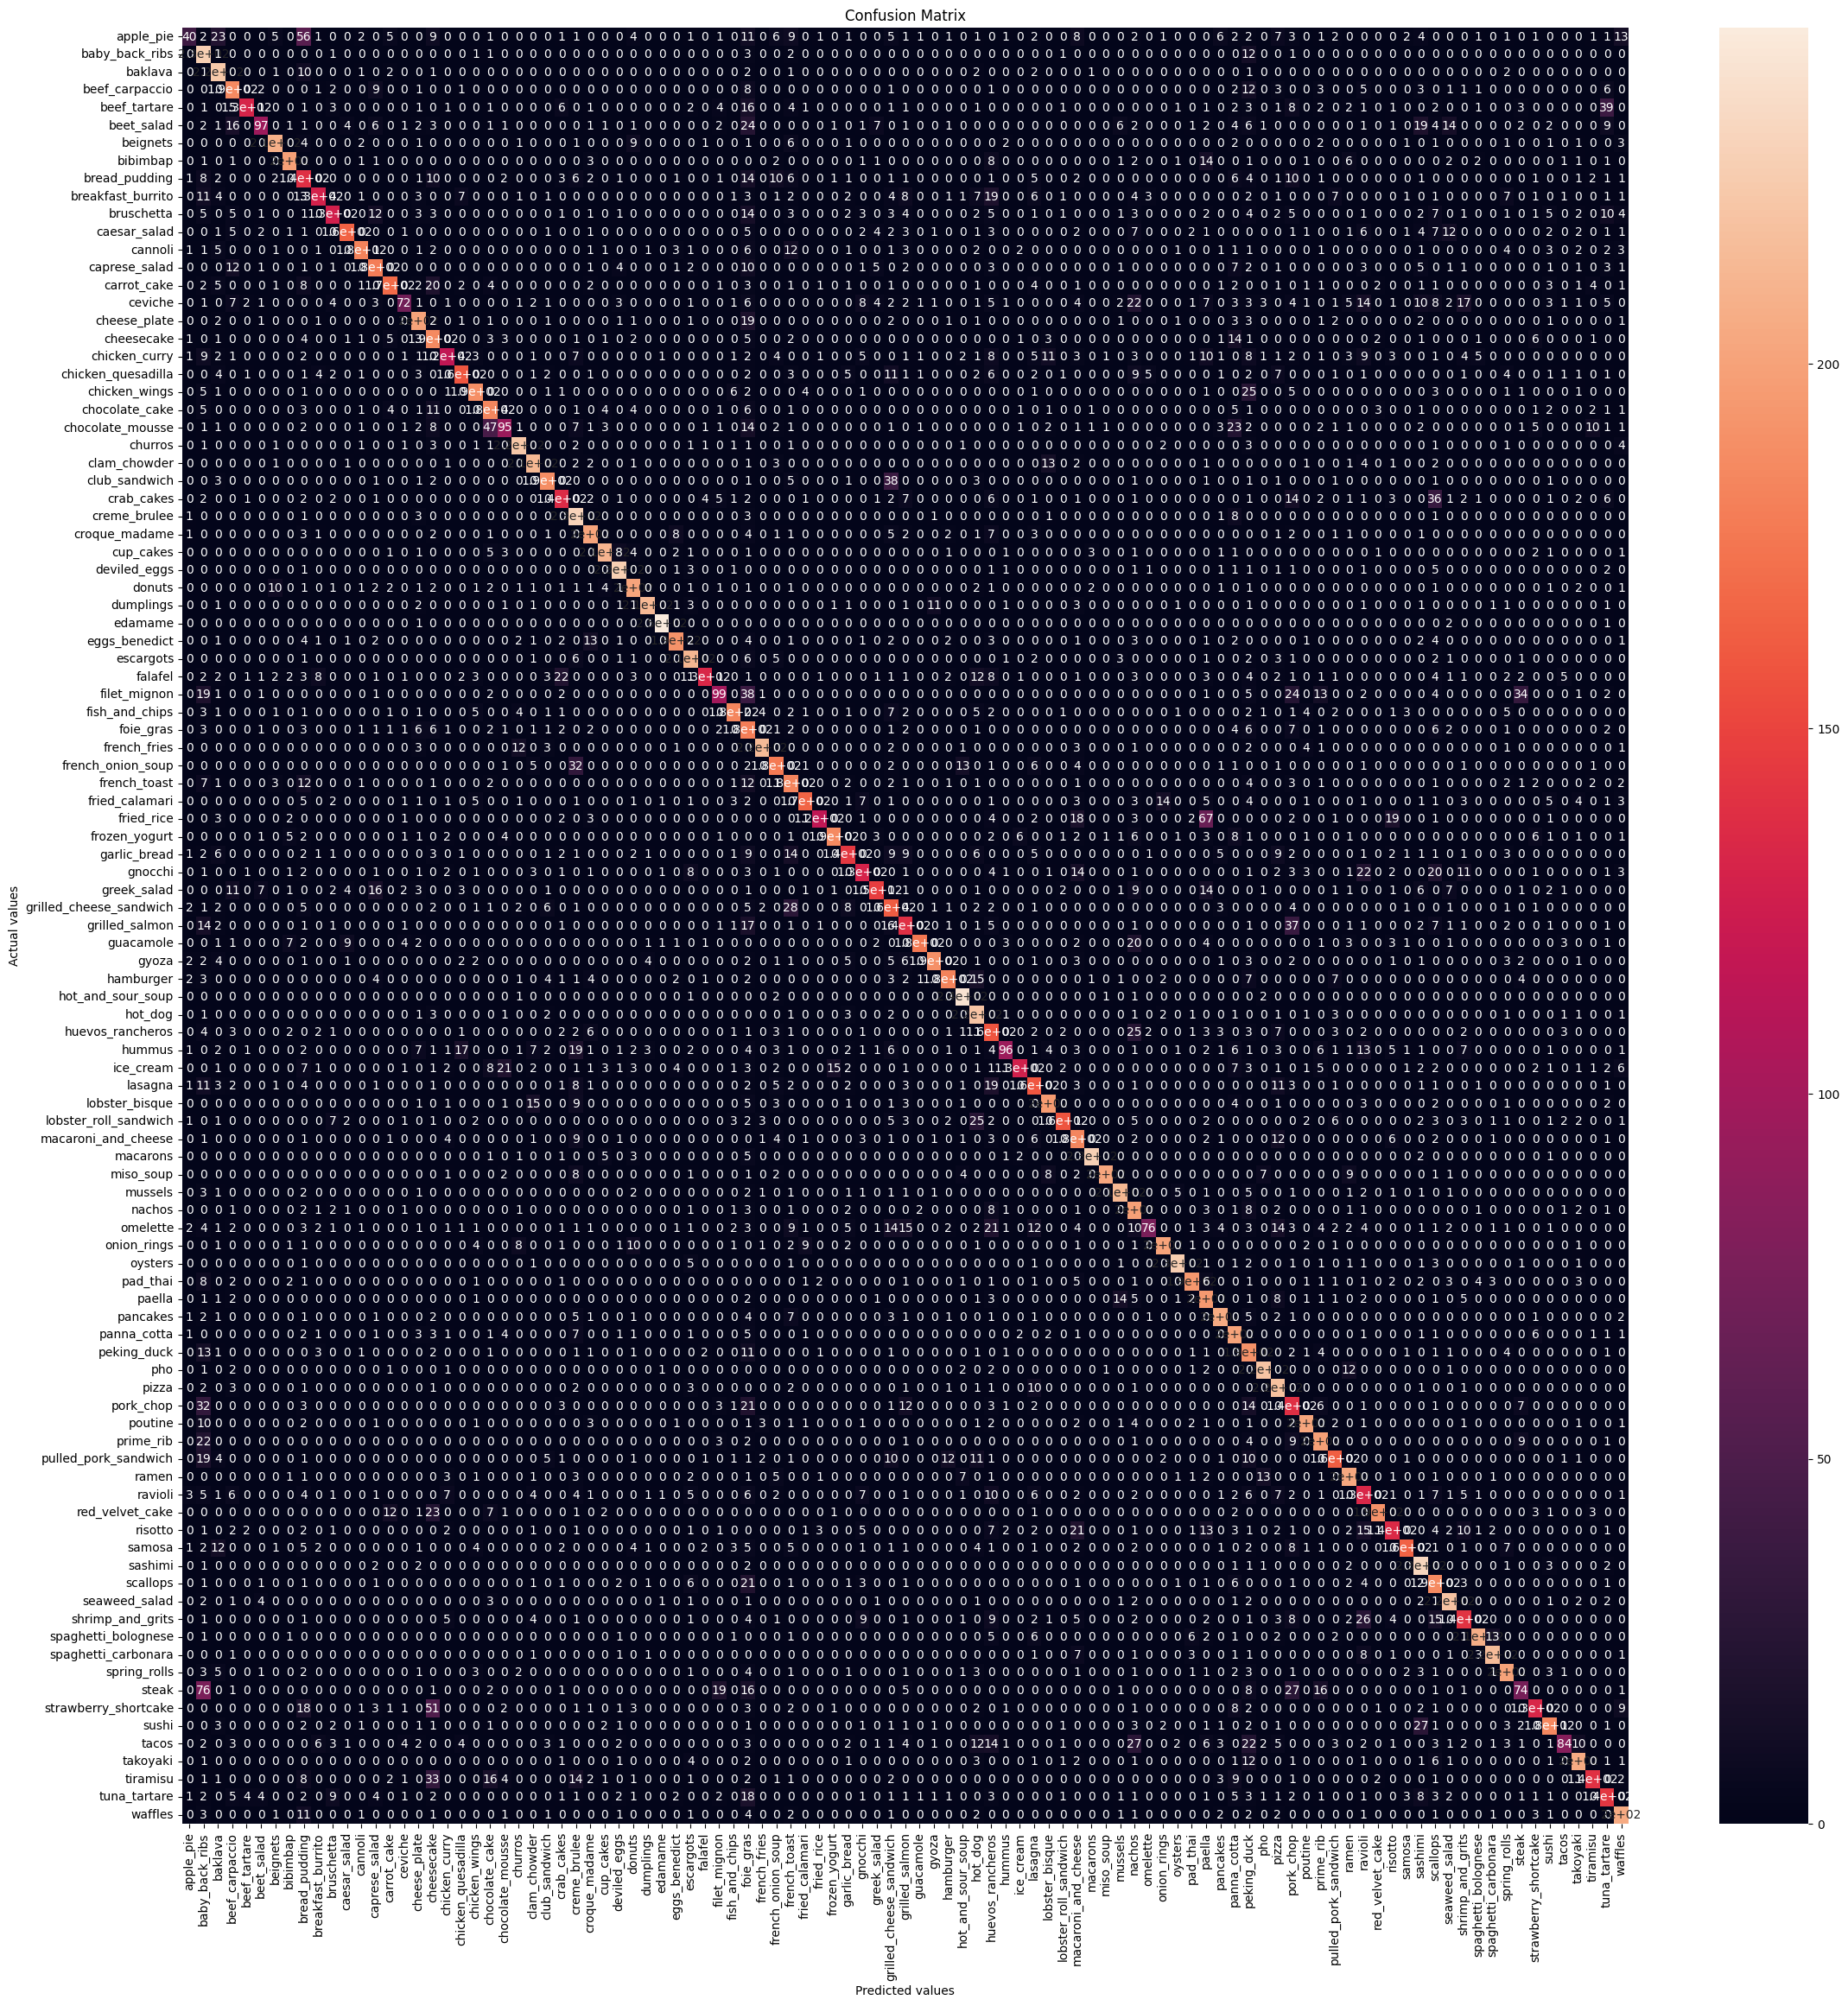

In [ ]:
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=category_names, columns = category_names)
plt.figure(figsize=(27, 27))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

### Vision Transformer

In [35]:
# Split the data into train, validation, and test sets
train_dir = "/content/kmader/train"
test_dir = "/content/kmader/test"
selected_folders = os.listdir(train_dir)
num_classes = len(selected_folders)
print("Number of classes", num_classes)

batch_size = 32
epochs = 10
patch_size = 7
image_size = 224
target_size = (224, 224)

# Create an ImageDataGenerator for data augmentation and preprocessing
train_data_generator = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_data_generator = ImageDataGenerator(
    rescale=1. / 255
)

# Generate the train set
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate the test set
validation_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

train_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch = validation_generator.n // validation_generator.batch_size

Number of classes 101
Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [36]:
class_map_101 = train_generator.class_indices
class_labels_101 = list(class_map_101.keys())
print(class_map_101)
print("")
print(class_labels_101)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [37]:
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)

347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [38]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


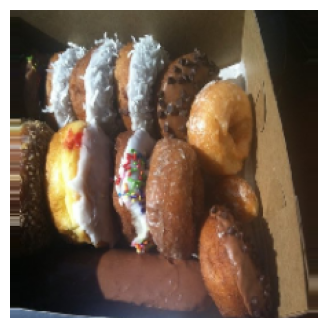

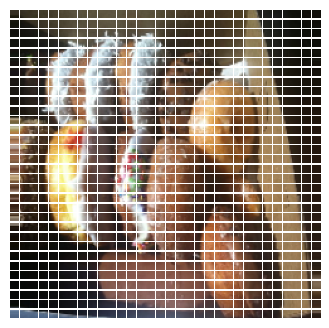

In [39]:
plt.figure(figsize=(4, 4))
# Calculate the number of patches based on the patch_size and image dimensions
num_patches = (image_size // patch_size) ** 2

image = train_generator[0][0][0]

plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')
plt.show()

In [40]:
model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tfa.activations.gelu),
    tf.keras.layers.Dense(32, activation=tfa.activations.gelu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')
], name='vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_94 (Ba  (None, 768)               3072      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 batch_normalization_95 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 64)         

In [ ]:
learning_rate = 1e-4
weight_decay = 1e-4
# optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)
# optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

# Define the path where you want to save the model checkpoints
checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/vit/vit_101_20_32_7_rectifiedadam/model_checkpoints/ckpt_{epoch:02d}.h5'

# Create a ModelCheckpoint callback to save the model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor='val_loss',
                                                      mode='min',
                                                      verbose=1)

# Define early stopping and reduce LR callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps_per_epoch,
                    epochs=epochs,
                    callbacks=[early_stopping, lr_schedule, model_checkpoint])

Epoch 1/20
2367/2367 [==============================] - ETA: 0s - loss: 3.8766 - accuracy: 0.3606
Epoch 1: val_loss improved from inf to 2.62719, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/vit/vit_101_20_32_7_rectifiedadam/model_checkpoints/ckpt_01.h5
2367/2367 [==============================] - 3506s 1s/step - loss: 3.8766 - accuracy: 0.3606 - val_loss: 2.6272 - val_accuracy: 0.7404 - lr: 1.0000e-04
Epoch 2/20
2367/2367 [==============================] - ETA: 0s - loss: 2.8705 - accuracy: 0.6829
Epoch 2: val_loss improved from 2.62719 to 2.26470, saving model to /content/gdrive/My Drive/DS 5500/Phase 2/vit/vit_101_20_32_7_rectifiedadam/model_checkpoints/ckpt_02.h5
2367/2367 [==============================] - 3464s 1s/step - loss: 2.8705 - accuracy: 0.6829 - val_loss: 2.2647 - val_accuracy: 0.8215 - lr: 1.0000e-04
Epoch 3/20
2367/2367 [==============================] - ETA: 0s - loss: 2.5848 - accuracy: 0.7638
Epoch 3: val_loss improved from 2.26470 to 2.17561, saving mod

To start training from a particular saved checkpoint

In [48]:
checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/vit/ckpt_10.h5'
model.load_weights(checkpoint_path)

learning_rate = 1e-4
weight_decay = 1e-4
# optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)
# optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

# # Define the path where you want to save the model checkpoints
# checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/vit/vit_101_32_20_7_rectifiedadam/ckpt_{epoch:02d}.h5'

# # Create a ModelCheckpoint callback to save the model
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                       save_weights_only=True,
#                                                       save_best_only=True,
#                                                       monitor='val_loss',
#                                                       mode='min',
#                                                       verbose=1)

# # Define early stopping and reduce LR callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
# lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# # Set the number of epochs to train
# epochs_to_train = 20
# initial_epoch = 11

# # Continue training from the 12th epoch and run the remaining epochs
# history = model.fit(train_generator,
#                     steps_per_epoch=train_steps_per_epoch,
#                     validation_data=validation_generator,
#                     validation_steps=validation_steps_per_epoch,
#                     epochs=epochs_to_train,
#                     initial_epoch=initial_epoch,
#                     callbacks=[early_stopping, lr_schedule, model_checkpoint],
#                     verbose=1
#                     )

In [ ]:
# Save the trained model
model.save("/content/gdrive/My Drive/DS 5500/Phase 2/vit/vit_101_32_20_7_rectifiedadam_final.h5")

In [49]:
# After training, evaluate the model on the validation set
test_error, test_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test accuracy: ", test_accuracy)

790/790 [==============================] - 2114s 3s/step - loss: 1.9884 - accuracy: 0.8695
Test accuracy:  0.8695445656776428


Predicting for one image

In [25]:
num_classes = 101
batch_size = 32
patch_size = 7
image_size = 224
target_size = (224, 224)

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tfa.activations.gelu),
    tf.keras.layers.Dense(32, activation=tfa.activations.gelu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')
], name='vision_transformer')

checkpoint_path = '/content/gdrive/My Drive/DS 5500/Phase 2/ckpt_11.h5'
model.load_weights(checkpoint_path)

sample_image_path = "/content/kmader/test/apple_pie/101251.jpg"
class_label_mapping = {'apple_pie': 'Apple pie', 'baby_back_ribs': 'Baby back ribs', 'baklava': 'Baklava', 'beef_carpaccio': 'Beef carpaccio', 'beef_tartare': 'Beef tartare', 'beet_salad': 'Beet salad', 'beignets': 'Beignets', 'bibimbap': 'Bibimbap', 'bread_pudding': 'Bread pudding', 'breakfast_burrito': 'Breakfast burrito', 'bruschetta': 'Bruschetta', 'caesar_salad': 'Caesar salad', 'cannoli': 'Cannoli', 'caprese_salad': 'Caprese salad', 'carrot_cake': 'Carrot cake', 'ceviche': 'Ceviche', 'cheesecake': 'Cheesecake', 'cheese_plate': 'Cheese plate', 'chicken_curry': 'Chicken curry', 'chicken_quesadilla': 'Chicken quesadilla', 'chicken_wings': 'Chicken wings', 'chocolate_cake': 'Chocolate cake', 'chocolate_mousse': 'Chocolate mousse', 'churros': 'Churros', 'clam_chowder': 'Clam chowder', 'club_sandwich': 'Club sandwich', 'crab_cakes': 'Crab cakes', 'creme_brulee': 'Creme brulee', 'croque_madame': 'Croque madame', 'cup_cakes': 'Cup cakes', 'deviled_eggs': 'Deviled eggs', 'donuts': 'Donuts', 'dumplings': 'Dumplings', 'edamame': 'Edamame', 'eggs_benedict': 'Eggs benedict', 'escargots': 'Escargots', 'falafel': 'Falafel', 'filet_mignon': 'Filet mignon', 'fish_and_chips': 'Fish and chips', 'foie_gras': 'Foie gras', 'french_fries': 'French fries', 'french_onion_soup': 'French onion soup', 'french_toast': 'French toast', 'fried_calamari': 'Fried calamari', 'fried_rice': 'Fried rice', 'frozen_yogurt': 'Frozen yogurt', 'garlic_bread': 'Garlic bread', 'gnocchi': 'Gnocchi', 'greek_salad': 'Greek salad', 'grilled_cheese_sandwich': 'Grilled cheese sandwich', 'grilled_salmon': 'Grilled salmon', 'guacamole': 'Guacamole', 'gyoza': 'Gyoza', 'hamburger': 'Hamburger', 'hot_and_sour_soup': 'Hot and sour soup', 'hot_dog': 'Hot dog', 'huevos_rancheros': 'Huevos rancheros', 'hummus': 'Hummus', 'ice_cream': 'Ice cream', 'lasagna': 'Lasagna', 'lobster_bisque': 'Lobster bisque', 'lobster_roll_sandwich': 'Lobster roll sandwich', 'macaroni_and_cheese': 'Macaroni and cheese', 'macarons': 'Macarons', 'miso_soup': 'Miso soup', 'mussels': 'Mussels', 'nachos': 'Nachos', 'omelette': 'Omelette', 'onion_rings': 'Onion rings', 'oysters': 'Oysters', 'pad_thai': 'Pad thai', 'paella': 'Paella', 'pancakes': 'Pancakes', 'panna_cotta': 'Panna cotta', 'peking_duck': 'Peking duck', 'pho': 'Pho', 'pizza': 'Pizza', 'pork_chop': 'Pork chop', 'poutine': 'Poutine', 'prime_rib': 'Prime rib', 'pulled_pork_sandwich': 'Pulled pork sandwich', 'ramen': 'Ramen', 'ravioli': 'Ravioli', 'red_velvet_cake': 'Red velvet cake', 'risotto': 'Risotto', 'samosa': 'Samosa', 'sashimi': 'Sashimi', 'scallops': 'Scallops', 'seaweed_salad': 'Seaweed salad', 'shrimp_and_grits': 'Shrimp and grits', 'spaghetti_bolognese': 'Spaghetti bolognese', 'spaghetti_carbonara': 'Spaghetti carbonara', 'spring_rolls': 'Spring rolls', 'steak': 'Steak', 'strawberry_shortcake': 'Strawberry shortcake', 'sushi': 'Sushi', 'tacos': 'Tacos', 'takoyaki': 'Takoyaki', 'tiramisu': 'Tiramisu', 'tuna_tartare': 'Tuna tartare', 'waffles': 'Waffles'}
class_map_101 = {'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 51, 'gyoza': 52, 'hamburger': 53, 'hot_and_sour_soup': 54, 'hot_dog': 55, 'huevos_rancheros': 56, 'hummus': 57, 'ice_cream': 58, 'lasagna': 59, 'lobster_bisque': 60, 'lobster_roll_sandwich': 61, 'macaroni_and_cheese': 62, 'macarons': 63, 'miso_soup': 64, 'mussels': 65, 'nachos': 66, 'omelette': 67, 'onion_rings': 68, 'oysters': 69, 'pad_thai': 70, 'paella': 71, 'pancakes': 72, 'panna_cotta': 73, 'peking_duck': 74, 'pho': 75, 'pizza': 76, 'pork_chop': 77, 'poutine': 78, 'prime_rib': 79, 'pulled_pork_sandwich': 80, 'ramen': 81, 'ravioli': 82, 'red_velvet_cake': 83, 'risotto': 84, 'samosa': 85, 'sashimi': 86, 'scallops': 87, 'seaweed_salad': 88, 'shrimp_and_grits': 89, 'spaghetti_bolognese': 90, 'spaghetti_carbonara': 91, 'spring_rolls': 92, 'steak': 93, 'strawberry_shortcake': 94, 'sushi': 95, 'tacos': 96, 'takoyaki': 97, 'tiramisu': 98, 'tuna_tartare': 99, 'waffles': 100}
class_labels_101 = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']
# Load and preprocess the image
image = load_img(sample_image_path, target_size=(image_size, image_size))
image = img_to_array(image)
image = image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape of the model
image = np.expand_dims(image, axis=0)

# Apply the Patches layer to the image batch to get patches
patches_layer = Patches(patch_size)
patches = patches_layer(image)

# Reshape the patches to match the model's input shape
patches = tf.reshape(patches, [-1, patch_size, patch_size, 3])

# Resize the patches to the expected input size of the model
resized_patches = tf.image.resize(patches, size=(224, 224))

# Make predictions on the resized patches
predictions = model.predict(resized_patches)

# Get the average predictions across patches
average_predictions = np.mean(predictions, axis=0)

# Get the predicted label index
predicted_label_index = np.argmax(average_predictions)

# Map the predicted label index to the actual class label
predicted_class_label = class_labels_101[predicted_label_index]

# Print the predicted label
print("Predicted class and label:", predicted_class_label, class_label_mapping[predicted_class_label])


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


32/32 [==============================] - 86s 3s/step
Predicted class and label: breakfast_burrito Breakfast burrito


Accuracy & Loss Curves

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

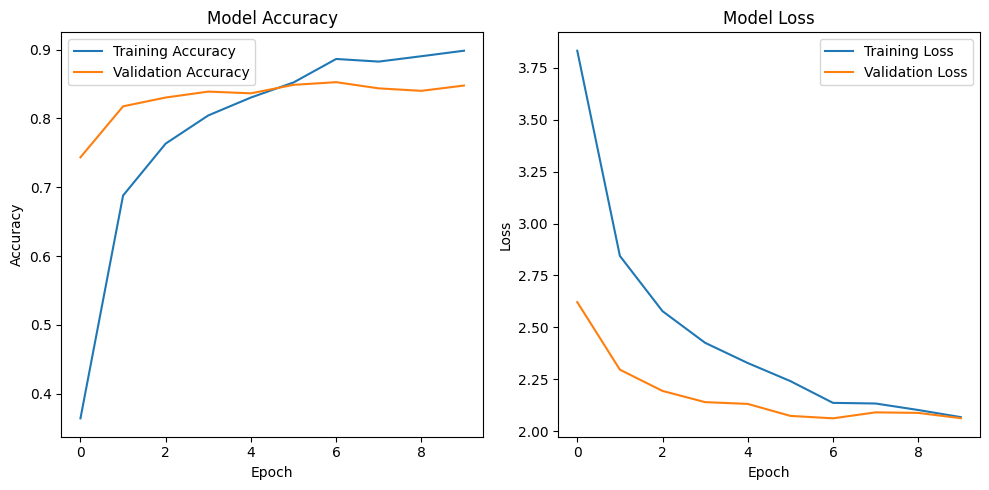

In [47]:
# Training history
history = {
    'loss': [3.8331, 2.8442, 2.5780, 2.4255, 2.3281, 2.2410, 2.1361, 2.1330, 2.1017, 2.0673],
    'accuracy': [0.3643, 0.6880, 0.7635, 0.8044, 0.8304, 0.8523, 0.8864, 0.8826, 0.8904, 0.8984],
    'val_loss': [2.62173, 2.29609, 2.19359, 2.13963, 2.13113, 2.07337, 2.06152, 2.0904, 2.0877, 2.0623],
    'val_accuracy': [0.7435, 0.8176, 0.8304, 0.8390, 0.8365, 0.8488, 0.8527, 0.8437, 0.8401, 0.8478]
}

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

# Continue with classification_report and print the report
category_names = list(train_generator.class_indices.keys())

report = classification_report(y_true_classes, y_pred_classes, target_names=category_names, zero_division=0)
# Print the classification report
print(report)

1/1 [==============================] - 3s 3s/step
                         precision    recall  f1-score   support

              apple_pie       0.71      0.74      0.72       250
         baby_back_ribs       0.87      0.88      0.88       249
                baklava       0.88      0.90      0.89       249
         beef_carpaccio       0.91      0.94      0.92       250
           beef_tartare       0.85      0.84      0.85       249
             beet_salad       0.82      0.84      0.83       249
               beignets       0.88      0.93      0.90       250
               bibimbap       0.98      0.91      0.94       250
          bread_pudding       0.71      0.71      0.71       250
      breakfast_burrito       0.85      0.79      0.82       251
             bruschetta       0.84      0.82      0.83       249
           caesar_salad       0.94      0.90      0.92       250
                cannoli       0.97      0.92      0.94       249
          caprese_salad       0.87     

Confusion Matrix

In [42]:
y_pred = []
y_true = []

# Make predictions batch by batch
for _ in range(validation_steps_per_epoch):
    X_val_batch, y_val_batch = next(validation_generator)
    y_pred_batch = model.predict(X_val_batch)

    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_val_batch, axis=1))

y_pred_classes = np.array(y_pred)
y_true_classes = np.array(y_true)

1/1 [==============================] - 3s 3s/step


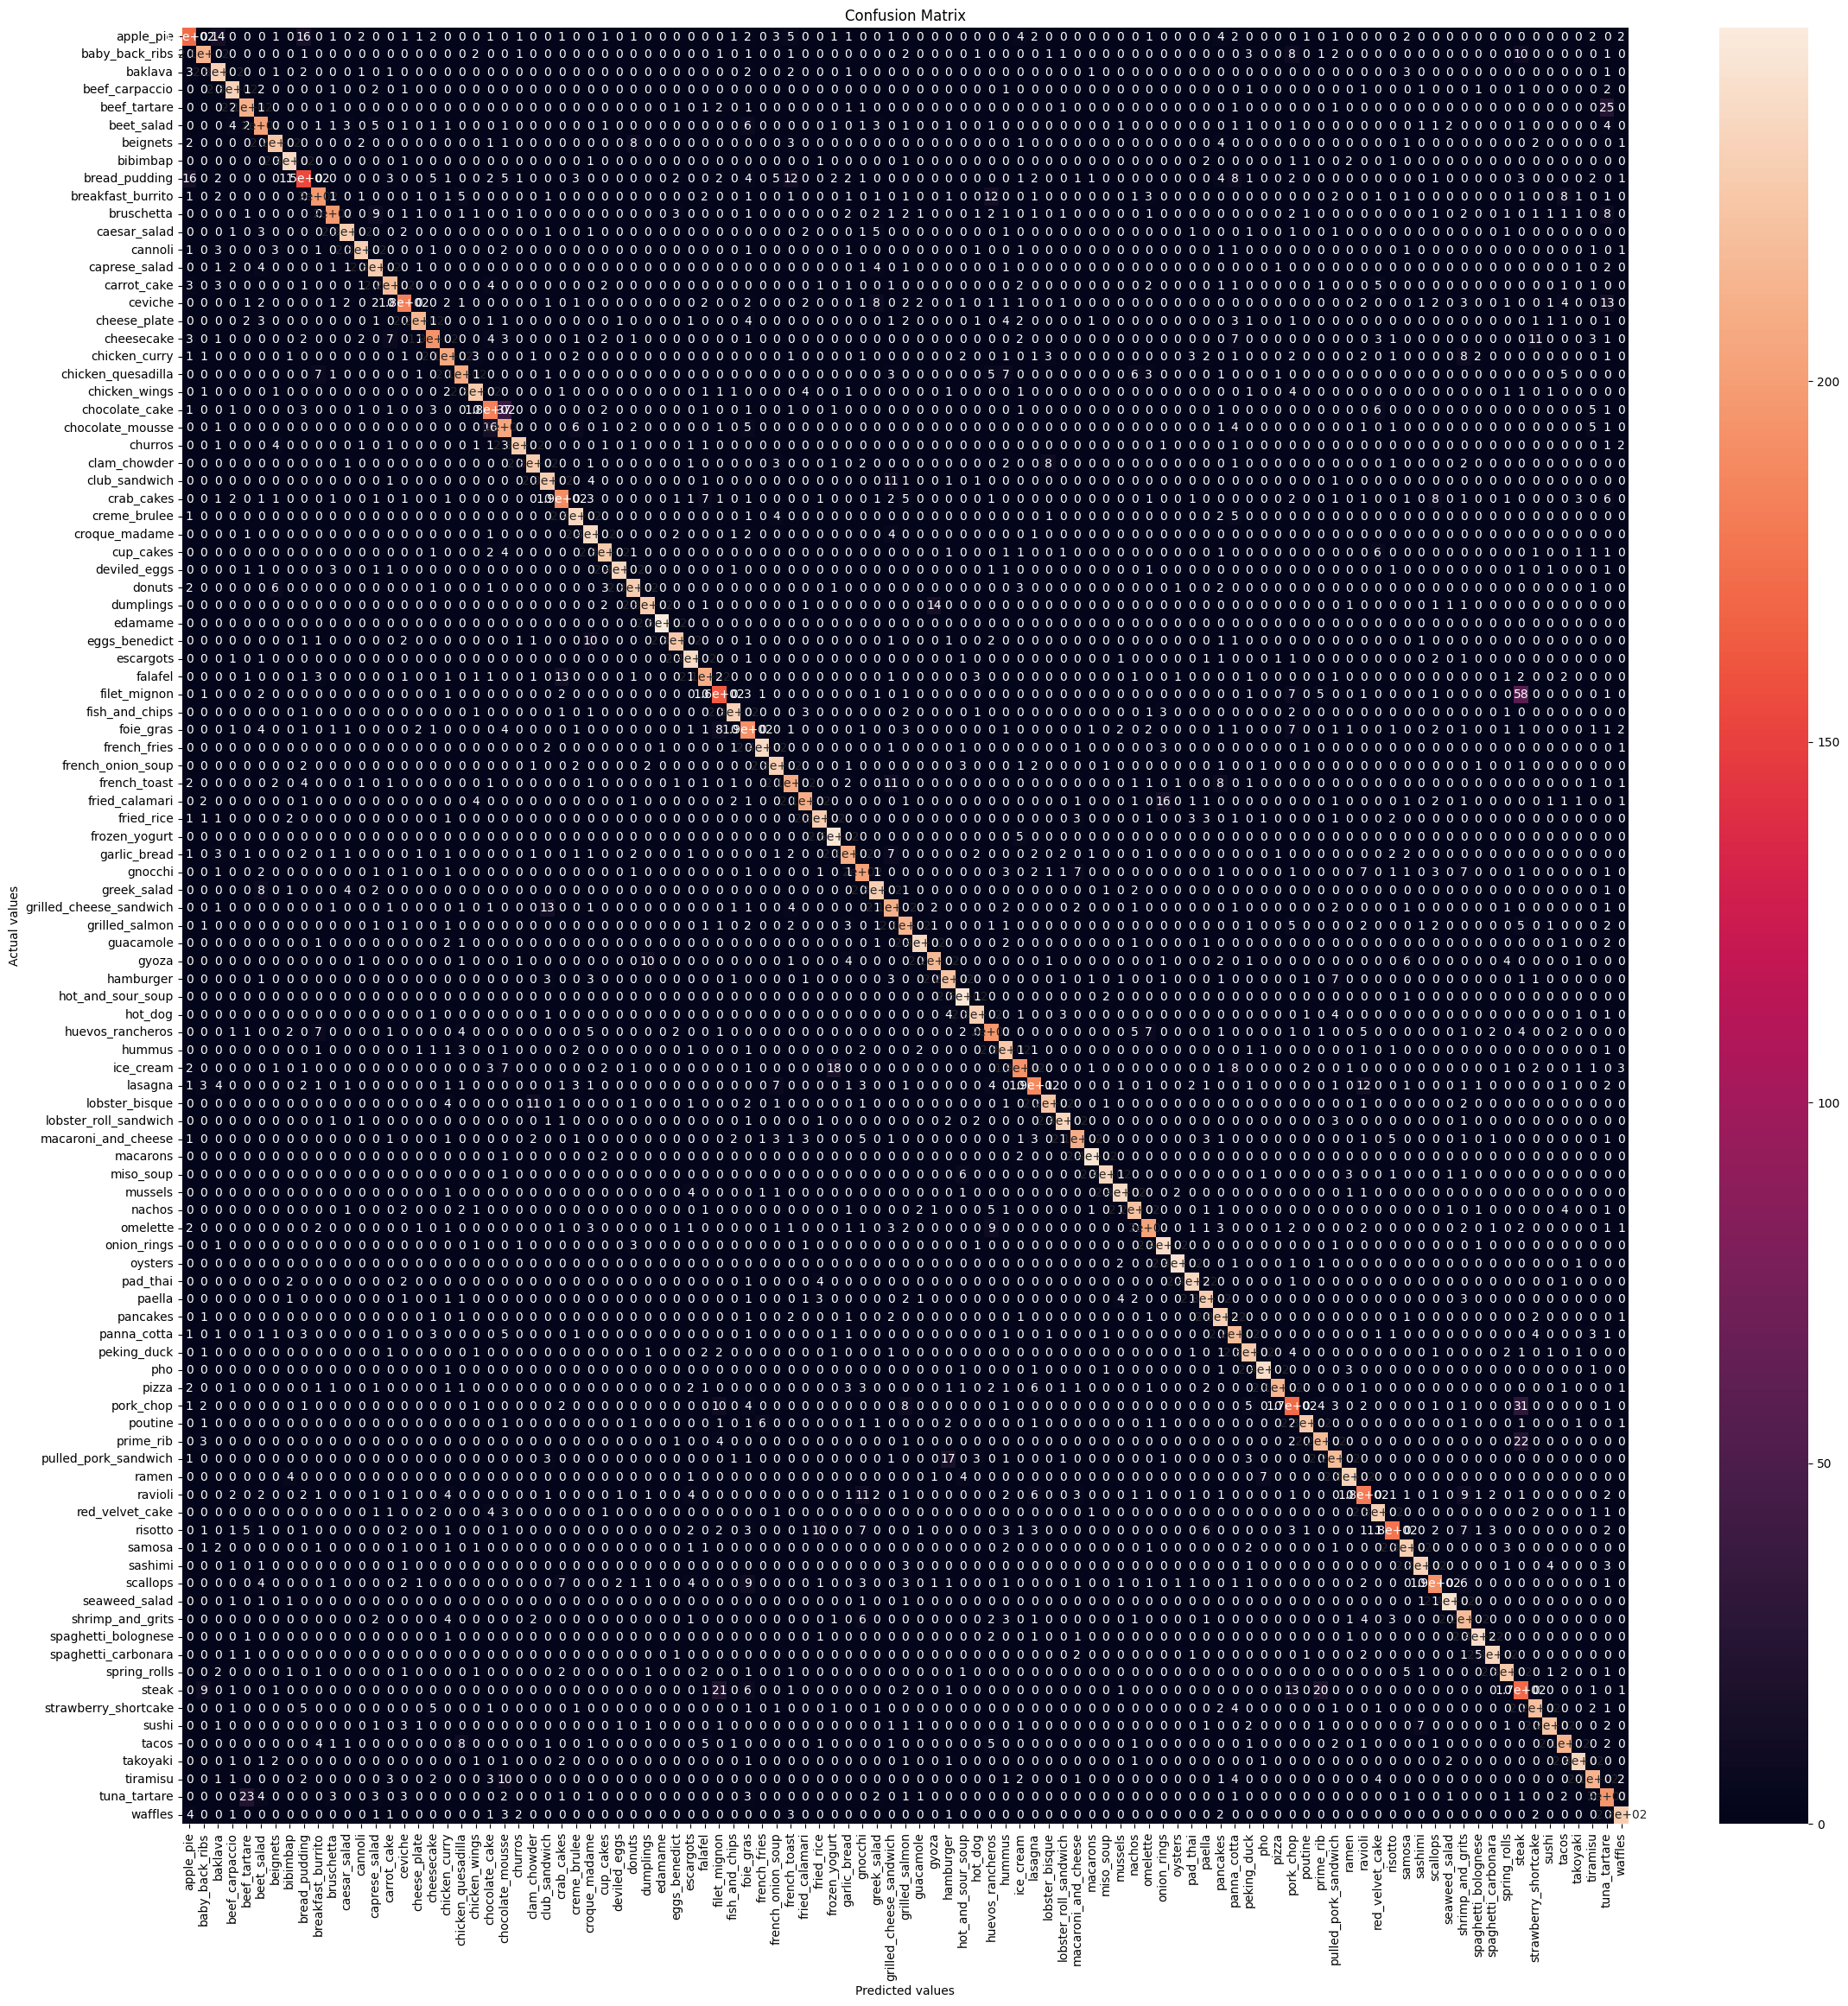

In [46]:
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=category_names, columns = category_names)
plt.figure(figsize=(27, 27))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()